# DTSC 691 Machine Learning Capstone Project:
# Predictive Ability of Paternal Characteristics on Prenatal and Perinatal Outcomes
## Rebecca Eng
## Spring 1 2023

## Goals of the project

Most of the research on prenatal and perinatal outcomes for mothers and infants focuses on maternal characteristics and demographics, and research on the impact of paternal characteristics and demographics is scarce (Mutsaerts et al., 2014).  However, the potential emotional and physical support fathers provide for the mother during the prenatal period may also play a role in outcomes for both the mother and the child.  Therefore, the intent of this project was to take a closer look at what paternal demographic characteristics can predict with regard to characteristics of the pregnancy and delivery and outcomes of the infant at birth.

A study by Mutsaerts et al. (2014) examined paternal and maternal lifestyle characteristics and the effect those had on the mother’s health during pregnancy.  Specifically, the study considered paternal age, height, weight, smoking habits, alcohol consumption, level of physical activity, educational level, number of hours worked per week, and household income as predictors of complications during pregnancy or delivery, such as issues related to hypertension, and gestational diabetes, preterm birth, infants born small for gestational age (Mutsaerts et al., 2014).  Results indicated that paternal factors were correlated with maternal factors and were not associated with the measured pregnancy outcomes after controlling for maternal factors (Mutsaerts et al., 2014).  

These results were not surprising given that the mother’s behaviors and lifestyle choices would be expected to have better predictive ability with these physical outcomes of the mother (hypertension, gestational diabetes, etc.) because they are more directly related to the mother’s physical health.  The present project attempted to examine social and environmental factors related to pregnancy and birth outcomes because fathers may have a more significant contribution to outcomes in those areas rather than on the physical health outcomes of the mother.  

Using the 2021 Natality Public Use File from the CDC (https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm#Births), the  project examined the predictive ability of paternal characteristics to pregnancy outcomes for the mother and infant.  Specifically, machine learning models were used to measure how the demographic characteristics of the father (race, age, marital status, and education) predict: 

Characteristics of the pregnancy and delivery:
* Number of prenatal care visits
* WIC
* Method of delivery (vaginal or cesarean)
* Trial of labor was attempted (if delivery was via cesarean)

Infant:
* Period of gestation
* Birth weight
* Infant breastfed at discharge

In addition, to determine how valuable the contribution of paternal characteristics is to predicting maternal and infant outcomes, the paternal results were compared with the predictive ability of the maternal demographics on the same variables, and the combination of the maternal and paternal characteristics was examined to see if this improved the predictive ability of the model.  It was hypothesized that paternal demographic characteristics would be predictive of the characteristics of the pregnancy and delivery and infant outcomes at birth and that inclusion of these paternal characteristics would improve the predictive ability of the maternal characteristics model when both sets of characteristics were combined.

In [57]:
#import standard libraries

import numpy as np
import pandas as pd
import joblib

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, figure

from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error

%matplotlib inline
mpl.rc('axes', titlesize=20)
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## Data Description

The full dataset consists of 3,669,928 records of live births of US residents born in the United States from the 50 states, New York City, and Washington DC during the year 2021.  Data were reported to the Centers for Disease Control and Prevention’s (CDC) National Center for Health Statistics (NCHS) by each state’s and city’s Vital Statistics Cooperative Program and aggregated at a national level.  Data includes all births occurring in the US to both US residents and non-residents, but does not include births to residents living in other countries.

The full dataset includes 225 variables, some of which are re-coded versions of other variables.  For example, mother’s race is reported in 31 potential categories, but then this information is re-coded into a 6 category variable and a 15 category variable.  Also, the data include variables indicating if data for variables was imputed or not reported.  The current project used 16 variables: mother’s age, race, Hispanic origin, marital status, and education level, father’s age, race, Hispanic origin, and education level, number of prenatal visits, whether or not WIC (support for Women, Infants and Children) benefits were received during pregnancy, trial of labor attempted (if delivered by cesarean), delivery method (vaginal or cesarean), number of weeks of gestation, birth weight, and report of whether or not the infant was breastfed at discharge.

Data files and the User’s Guide can be downloaded from https://www.cdc.gov/nchs/data_access/VitalStatsOnline.htm 

In [58]:
#import data

colspecs = [(74, 76), (104, 106), (114, 115), (119, 120), (123, 124), (146, 148), (150, 152), (159, 160), 
            (162, 163), (237, 239), (250, 251), (402, 403), (407, 408), (498, 500), (502, 503), (503, 507), (568, 569)]
colnames = ['MAGER', 'MRACE31', 'MHISP_R', 'DMAR', 'MEDUC', 'FAGECOMB', 'FRACE31', 'FHISP_R', 'FEDUC', 'PREVIS', 
           'WIC', 'ME_TRIAL', 'DMETH_REC', 'OEGEST_COMB', 'OEGEST_R3', 'DBWT', 'BFED']

data = pd.read_fwf('Nat2021US.txt', colspecs=colspecs, names=colnames)
data.head()

,MAGER,MRACE31,MHISP_R,DMAR,MEDUC,FAGECOMB,FRACE31,FHISP_R,FEDUC,PREVIS,WIC,ME_TRIAL,DMETH_REC,OEGEST_COMB,OEGEST_R3,DBWT,BFED
0,22,1,4,1.0,3,23,99,2,4,99,Y,X,1,40,2,3670,Y
1,31,22,0,2.0,4,27,5,0,3,99,N,X,1,39,2,3210,Y
2,29,1,0,2.0,4,29,1,0,4,8,N,X,1,40,2,3997,Y
3,39,1,3,2.0,6,40,1,0,5,10,N,X,1,39,2,3510,Y
4,20,5,0,2.0,3,28,5,0,3,11,N,X,1,38,2,3100,N


## Descriptive and Exploratory Analyses

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669928 entries, 0 to 3669927
Data columns (total 17 columns):
 #   Column       Dtype  
---  ------       -----  
 0   MAGER        int64  
 1   MRACE31      int64  
 2   MHISP_R      int64  
 3   DMAR         float64
 4   MEDUC        int64  
 5   FAGECOMB     int64  
 6   FRACE31      int64  
 7   FHISP_R      int64  
 8   FEDUC        int64  
 9   PREVIS       int64  
 10  WIC          object 
 11  ME_TRIAL     object 
 12  DMETH_REC    int64  
 13  OEGEST_COMB  int64  
 14  OEGEST_R3    int64  
 15  DBWT         int64  
 16  BFED         object 
dtypes: float64(1), int64(13), object(3)
memory usage: 476.0+ MB


In [60]:
data.describe()

,MAGER,MRACE31,MHISP_R,DMAR,MEDUC,FAGECOMB,FRACE31,FHISP_R,FEDUC,PREVIS,DMETH_REC,OEGEST_COMB,OEGEST_R3,DBWT
count,3.669928e+06,3.669928e+06,3.669928e+06,3.248840e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06,3.669928e+06
mean,2.940777e+01,1.632705e+00,6.498057e-01,1.401112e+00,4.520693e+00,3.953426e+01,1.946897e+01,1.616333e+00,4.950681e+00,1.278668e+01,1.327051e+00,3.838317e+01,1.896093e+00,3.256086e+03
std,5.771910e+00,1.836997e+00,1.517602e+00,4.901238e-01,1.823082e+00,2.207427e+01,3.771031e+01,3.045347e+00,2.285996e+00,1.305470e+01,5.152668e-01,2.741673e+00,3.079186e-01,6.239533e+02
min,1.200000e+01,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.000000e+00,2.270000e+02
25%,2.500000e+01,1.000000e+00,0.000000e+00,1.000000e+00,3.000000e+00,2.800000e+01,1.000000e+00,0.000000e+00,3.000000e+00,9.000000e+00,1.000000e+00,3.800000e+01,2.000000e+00,2.948000e+03
50%,3.000000e+01,1.000000e+00,0.000000e+00,1.000000e+00,4.000000e+00,3.300000e+01,1.000000e+00,0.000000e+00,4.000000e+00,1.100000e+01,1.000000e+00,3.900000e+01,2.000000e+00,3.290000e+03
75%,3.400000e+01,2.000000e+00,1.000000e+00,2.000000e+00,6.000000e+00,3.800000e+01,4.000000e+00,1.000000e+00,6.000000e+00,1.300000e+01,2.000000e+00,3.900000e+01,2.000000e+00,3.620000e+03
max,5.000000e+01,3.100000e+01,9.000000e+00,2.000000e+00,9.000000e+00,9.900000e+01,9.900000e+01,9.000000e+00,9.000000e+00,9.900000e+01,9.000000e+00,9.900000e+01,3.000000e+00,9.999000e+03


In [61]:
corr = data.corr()

In [62]:
corr.style.background_gradient(cmap='coolwarm')

,MAGER,MRACE31,MHISP_R,DMAR,MEDUC,FAGECOMB,FRACE31,FHISP_R,FEDUC,PREVIS,DMETH_REC,OEGEST_COMB,OEGEST_R3,DBWT
MAGER,1.000000,0.012027,-0.032528,-0.358230,0.389519,0.038594,-0.147357,-0.160365,0.115011,0.023031,0.118862,-0.026194,-0.024805,0.036779
MRACE31,0.012027,1.000000,-0.051263,0.048809,0.020746,0.034467,0.018357,0.005565,0.048987,0.007940,0.002054,-0.011740,-0.008929,-0.043489
MHISP_R,-0.032528,-0.051263,1.000000,0.103544,-0.074686,0.007097,0.247633,0.321039,-0.050881,0.008621,0.017607,0.023663,0.003267,0.001871
DMAR,-0.358230,0.048809,0.103544,1.000000,-0.425660,0.323576,0.390273,0.422552,0.040457,-0.023951,-0.004260,-0.040713,-0.043593,-0.110566
MEDUC,0.389519,0.020746,-0.074686,-0.425660,1.000000,-0.140060,-0.233613,-0.234759,0.335856,0.043571,0.029331,0.043890,0.034702,0.070662
FAGECOMB,0.038594,0.034467,0.007097,0.323576,-0.140060,1.000000,0.706128,0.801394,0.650974,-0.013415,0.026252,-0.038594,-0.052186,-0.076934
FRACE31,-0.147357,0.018357,0.247633,0.390273,-0.233613,0.706128,1.000000,0.804617,0.458122,-0.008094,0.005961,-0.020641,-0.039678,-0.071288
FHISP_R,-0.160365,0.005565,0.321039,0.422552,-0.234759,0.801394,0.804617,1.000000,0.521492,-0.012649,0.009151,-0.024059,-0.043233,-0.077236
FEDUC,0.115011,0.048987,-0.050881,0.040457,0.335856,0.650974,0.458122,0.521492,1.000000,0.011834,0.008349,0.006808,-0.010236,-0.020817
PREVIS,0.023031,0.007940,0.008621,-0.023951,0.043571,-0.013415,-0.008094,-0.012649,0.011834,1.000000,0.050981,0.066099,0.018779,0.037120


In [63]:
data.isna().sum()

MAGER               0
MRACE31             0
MHISP_R             0
DMAR           421088
MEDUC               0
FAGECOMB            0
FRACE31             0
FHISP_R             0
FEDUC               0
PREVIS              0
WIC                 0
ME_TRIAL            0
DMETH_REC           0
OEGEST_COMB         0
OEGEST_R3           0
DBWT                0
BFED                0
dtype: int64

In [64]:
### marital status of mother: 1=married, 2=unmarried
data['DMAR'].value_counts()

1.0    1945690
2.0    1303150
Name: DMAR, dtype: int64

In [65]:
### percentage marital status of mother: 1=married, 2=unmarried
data['DMAR'].value_counts(normalize=True)

1.0    0.598888
2.0    0.401112
Name: DMAR, dtype: float64

## Boxplots of Continuous Variables

{'whiskers': [<matplotlib.lines.Line2D at 0x18000f8fb50>,
 'caps': [<matplotlib.lines.Line2D at 0x1800b8da730>,
 'boxes': [<matplotlib.lines.Line2D at 0x18002177400>],
 'medians': [<matplotlib.lines.Line2D at 0x18002198550>],
 'fliers': [<matplotlib.lines.Line2D at 0x18002198580>],
 'means': []}

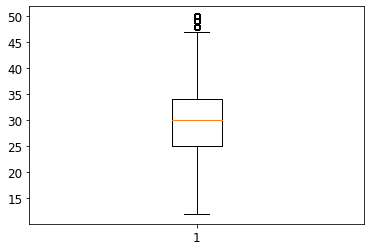

In [66]:
plt.boxplot(data.MAGER)

{'whiskers': [<matplotlib.lines.Line2D at 0x18002fe6910>,
 'caps': [<matplotlib.lines.Line2D at 0x18002fe6fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18002fe65b0>],
 'medians': [<matplotlib.lines.Line2D at 0x18002fd56d0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18002fd5a30>],
 'means': []}

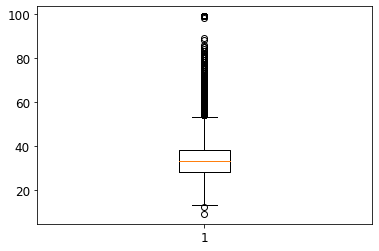

In [67]:
plt.boxplot(data.FAGECOMB)

{'whiskers': [<matplotlib.lines.Line2D at 0x180045229d0>,
 'caps': [<matplotlib.lines.Line2D at 0x180045300d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18004522670>],
 'medians': [<matplotlib.lines.Line2D at 0x18004530790>],
 'fliers': [<matplotlib.lines.Line2D at 0x18004530af0>],
 'means': []}

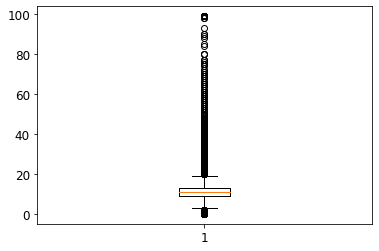

In [68]:
plt.boxplot(data.PREVIS)

{'whiskers': [<matplotlib.lines.Line2D at 0x1800471dfd0>,
 'caps': [<matplotlib.lines.Line2D at 0x180047296d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1800471dc70>],
 'medians': [<matplotlib.lines.Line2D at 0x18004729d90>],
 'fliers': [<matplotlib.lines.Line2D at 0x18004736130>],
 'means': []}

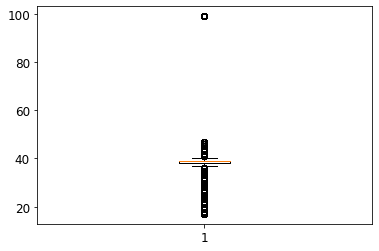

In [69]:
plt.boxplot(data.OEGEST_COMB)

{'whiskers': [<matplotlib.lines.Line2D at 0x18004785100>,
 'caps': [<matplotlib.lines.Line2D at 0x180047857f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x18004775d60>],
 'medians': [<matplotlib.lines.Line2D at 0x18004785eb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x18004790250>],
 'means': []}

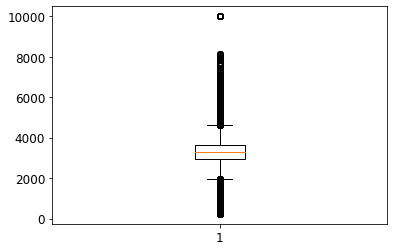

In [70]:
plt.boxplot(data.DBWT)

### Maternal Demographic Characteristics

In [71]:
### mother education level
data['MEDUC'] = data.MEDUC.replace([9], [np.nan])
data['MEDUC'].value_counts(normalize=True)

3.0    0.261980
6.0    0.220422
4.0    0.186096
7.0    0.104625
5.0    0.085304
2.0    0.080729
8.0    0.030853
1.0    0.029989
Name: MEDUC, dtype: float64

(array([108350., 291669., 946517., 672353., 308199., 796371., 378004.,
        111469.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

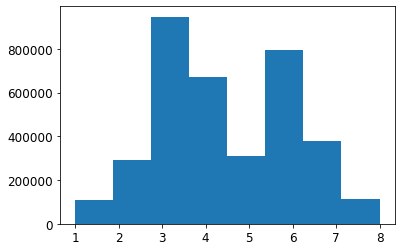

In [72]:
plt.hist(data.MEDUC, bins=8)

In [73]:
### mother age
data['MAGER'].value_counts()

31    242336
30    240183
29    232272
32    229576
28    220169
33    212042
27    206529
34    192780
26    190999
25    175662
35    171078
24    160214
23    146107
36    144471
22    131701
37    115119
21    114403
20     96676
38     91775
19     71324
39     70796
40     50499
18     40206
41     34241
42     21705
17     20792
43     13037
16     10322
44      7104
15      4479
45      3916
46      2144
14      1484
47      1171
50      1054
48       689
49       476
13       326
12        71
Name: MAGER, dtype: int64

In [74]:
data['MAGER'].mean()

29.407765492947

In [75]:
### mother race
data['MRACE31'].value_counts(normalize=True)

1     0.739273
2     0.157311
4     0.061932
6     0.012053
3     0.009502
13    0.005971
10    0.004512
5     0.003599
25    0.000992
7     0.000832
16    0.000797
15    0.000778
8     0.000725
14    0.000614
19    0.000314
9     0.000181
22    0.000137
11    0.000114
21    0.000060
30    0.000052
20    0.000039
12    0.000038
26    0.000037
23    0.000036
17    0.000032
29    0.000026
18    0.000015
24    0.000011
28    0.000008
31    0.000008
27    0.000002
Name: MRACE31, dtype: float64

In [76]:
### mother Hispanic origin
data['MHISP_R'] = data.MHISP_R.replace([9], [np.nan])
data['MHISP_R'].value_counts(normalize=True)

0.0    0.754966
1.0    0.134668
4.0    0.049041
5.0    0.035128
2.0    0.019470
3.0    0.006727
Name: MHISP_R, dtype: float64


### Paternal Demographic Characteristics

In [77]:
### father age
data['FAGECOMB'] = data.FAGECOMB.replace([99], [np.nan])
data['FAGECOMB'].value_counts(normalize=True)

31.0    6.312413e-02
32.0    6.260630e-02
33.0    6.094630e-02
30.0    5.988485e-02
34.0    5.789272e-02
            ...     
12.0    3.069538e-07
9.0     3.069538e-07
88.0    3.069538e-07
89.0    3.069538e-07
86.0    3.069538e-07
Name: FAGECOMB, Length: 79, dtype: float64

In [78]:
data['FAGECOMB'].mean()

32.0119392759389

In [79]:
### father race
data['FRACE31'] = data.FRACE31.replace([99], [np.nan])
data['FRACE31'].value_counts(normalize=True)

1.0     0.744188
2.0     0.155305
4.0     0.062272
6.0     0.010142
3.0     0.007631
13.0    0.006123
10.0    0.004528
5.0     0.003479
7.0     0.001121
25.0    0.001003
15.0    0.000930
8.0     0.000799
16.0    0.000721
14.0    0.000664
19.0    0.000251
9.0     0.000249
22.0    0.000130
11.0    0.000106
21.0    0.000064
12.0    0.000051
30.0    0.000049
17.0    0.000036
23.0    0.000035
20.0    0.000031
26.0    0.000026
29.0    0.000020
18.0    0.000016
24.0    0.000010
28.0    0.000009
31.0    0.000006
27.0    0.000003
Name: FRACE31, dtype: float64

In [80]:
### father Hispanic origin
data['FHISP_R'] = data.FHISP_R.replace([9], [np.nan])
data['FHISP_R'].value_counts()

0.0    2441241
1.0     425741
4.0     141852
5.0     113160
2.0      59793
3.0      23330
Name: FHISP_R, dtype: int64

In [81]:
### father education level
data['FEDUC'] = data.FEDUC.replace([9], [np.nan])
data['FEDUC'].value_counts(normalize=True)

3.0    0.305107
6.0    0.210521
4.0    0.178907
7.0    0.081242
2.0    0.078989
5.0    0.074091
8.0    0.035866
1.0    0.035277
Name: FEDUC, dtype: float64

(array([111861., 250466., 967464., 567294., 234935., 667540., 257610.,
        113726.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

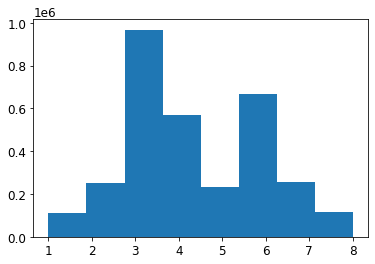

In [82]:
plt.hist(data.FEDUC, bins=8)

### Pregnancy and Infant Outcomes

In [83]:
### number of prenatal visits
data['PREVIS'] = data.PREVIS.replace([99], [np.nan])
data['PREVIS'].value_counts()

12.0    546041
10.0    502048
11.0    398615
13.0    335151
9.0     263975
         ...  
93.0         1
85.0         1
84.0         1
76.0         1
74.0         1
Name: PREVIS, Length: 83, dtype: int64

In [84]:
#number of observations with 0 prenatal visits
data['PREVIS'].loc[data['PREVIS'] == 0].count()

74900

In [85]:
#mean number of visits among those who had at least 1 prenatal visit
data['PREVIS'].loc[(data['PREVIS'] != 0)].mean()

11.248370675915313

In [86]:
#mean number of visits including those who had 0 prenatal visits
data['PREVIS'].mean()

11.014081232661251

In [87]:
# received WIC during pregnancy
data['WIC'].value_counts(normalize=True)

N    0.693840
Y    0.294908
U    0.011252
Name: WIC, dtype: float64

In [88]:
# attempted a trial of labor prior to cesarean Y=yes, N=no, U=unknown, X=not applicable (delivered vaginally)
data['ME_TRIAL'].value_counts(normalize=True)

X    0.678626
N    0.229298
Y    0.087671
U    0.004405
Name: ME_TRIAL, dtype: float64

In [89]:
# method of delivery 1=vaginal, 2=cesarean, 9=missing
data['DMETH_REC'] = data.DMETH_REC.replace([9], [np.nan])
data['DMETH_REC'].value_counts(normalize=True)

1.0    0.679176
2.0    0.320824
Name: DMETH_REC, dtype: float64

In [117]:
# weeks of gestation, range= 17-47, 99=missing
data['OEGEST_COMB'] = data.OEGEST_COMB.replace([99], [np.nan])
data['OEGEST_COMB'].value_counts(normalize=True)

39.0    0.383822
40.0    0.175230
38.0    0.171702
37.0    0.115890
41.0    0.046053
36.0    0.041885
35.0    0.020051
34.0    0.014787
33.0    0.007162
32.0    0.005057
31.0    0.003210
30.0    0.002745
42.0    0.002279
29.0    0.001877
28.0    0.001651
27.0    0.001337
26.0    0.001122
25.0    0.000994
24.0    0.000908
23.0    0.000708
22.0    0.000463
21.0    0.000320
20.0    0.000255
19.0    0.000158
43.0    0.000124
18.0    0.000103
17.0    0.000056
44.0    0.000029
45.0    0.000009
47.0    0.000007
46.0    0.000006
Name: OEGEST_COMB, dtype: float64

In [122]:
# infant weight in grams at birth, 9999=missing
data['DBWT'] = data.DBWT.replace([9999], [np.nan])
data['DBWT'].mean()

3249.790906599064

In [92]:
# infant being breastfed at discharge Y=yes, N=no, U=unknown
data['BFED'].value_counts(normalize=True)

Y    0.732438
N    0.146419
U    0.121143
Name: BFED, dtype: float64

## Recoding of Data to Numeric

In [93]:
#change letters to numbers for WIC data
data['WIC_R'] = data.WIC.replace(['Y', 'N', 'U'], [1, 0, np.nan])
data['WIC_R'].value_counts(normalize=True)

0.0    0.701736
1.0    0.298264
Name: WIC_R, dtype: float64

In [94]:
#change letters to numbers for labor trial data 
data['TRIAL_R'] = data.ME_TRIAL.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])
data['TRIAL_R'].value_counts(normalize=True)

1.0    0.769687
0.0    0.230313
Name: TRIAL_R, dtype: float64

In [95]:
#change letters to numbers for breastfeeding data
data['BFED_R'] = data.BFED.replace(['Y', 'N', 'U'], [1, 0, np.nan])
data['BFED_R'].value_counts(normalize=True)

1.0    0.833399
0.0    0.166601
Name: BFED_R, dtype: float64

In [96]:
data.isnull().sum()

MAGER               0
MRACE31             0
MHISP_R         36643
DMAR           421088
MEDUC           56996
FAGECOMB       412109
FRACE31        672581
FHISP_R        464811
FEDUC          499032
PREVIS          73936
WIC                 0
ME_TRIAL            0
DMETH_REC        2976
OEGEST_COMB      3126
OEGEST_R3           0
DBWT             3423
BFED                0
WIC_R           41295
TRIAL_R         16167
BFED_R         444586
dtype: int64

In [97]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3669928 entries, 0 to 3669927
Data columns (total 20 columns):
 #   Column       Dtype  
---  ------       -----  
 0   MAGER        int64  
 1   MRACE31      int64  
 2   MHISP_R      float64
 3   DMAR         float64
 4   MEDUC        float64
 5   FAGECOMB     float64
 6   FRACE31      float64
 7   FHISP_R      float64
 8   FEDUC        float64
 9   PREVIS       float64
 10  WIC          object 
 11  ME_TRIAL     object 
 12  DMETH_REC    float64
 13  OEGEST_COMB  float64
 14  OEGEST_R3    int64  
 15  DBWT         float64
 16  BFED         object 
 17  WIC_R        float64
 18  TRIAL_R      float64
 19  BFED_R       float64
dtypes: float64(14), int64(3), object(3)
memory usage: 560.0+ MB


## Taking a Stratified Random Sample for Analyses

In [ ]:
sample_data = data.sample(n=1000000)
sample_data.info()

In [ ]:
sample_data['WIC'].value_counts(normalize=True)

In [ ]:
sample_data['ME_TRIAL'].value_counts(normalize=True)

In [ ]:
sample_data['DMETH_REC'].value_counts(normalize=True)

In [ ]:
sample_data['BFED'].value_counts(normalize=True)

In [ ]:
### mother education level
sample_data['MEDUC'] = sample_data.MEDUC.replace([9], [np.nan])
sample_data['MEDUC'].value_counts(normalize=True)

In [ ]:
### mother Hispanic origin
sample_data['MHISP_R'] = sample_data.MHISP_R.replace([9], [np.nan])
sample_data['MHISP_R'].value_counts(normalize=True)

In [ ]:
### father age
sample_data['FAGECOMB'] = sample_data.FAGECOMB.replace([99], [np.nan])
sample_data['FAGECOMB'].value_counts(normalize=True)

In [ ]:
### father race
sample_data['FRACE31'] = sample_data.FRACE31.replace([99], [np.nan])
sample_data['FRACE31'].value_counts(normalize=True)

In [ ]:
### father Hispanic origin
sample_data['FHISP_R'] = sample_data.FHISP_R.replace([9], [np.nan])
sample_data['FHISP_R'].value_counts()

In [ ]:
### father education level
sample_data['FEDUC'] = sample_data.FEDUC.replace([9], [np.nan])
sample_data['FEDUC'].value_counts(normalize=True)

In [ ]:
### number of prenatal visits
sample_data['PREVIS'] = sample_data.PREVIS.replace([99], [np.nan])
sample_data['PREVIS'].value_counts()

In [ ]:
# method of delivery 1=vaginal, 2=cesarean, 99=missing
sample_data['DMETH_REC'] = sample_data.DMETH_REC.replace([9], [np.nan])
sample_data['DMETH_REC'].value_counts(normalize=True)

In [ ]:
# weeks of gestation, range= 17-47, 99=missing
sample_data['OEGEST_COMB'] = sample_data.OEGEST_COMB.replace([99], [np.nan])
sample_data['OEGEST_COMB'].value_counts()

In [ ]:
# infant weight in grams at birth, 99=missing
sample_data['DBWT'] = sample_data.DBWT.replace([9999], [np.nan])
sample_data['DBWT'].value_counts(normalize=True)

In [ ]:
# infant being breastfed at discharge Y=yes, N=no, U=unknown
sample_data['BFED'].value_counts(normalize=True)

In [ ]:
#change letters to numbers for WIC data
sample_data['WIC_R'] = sample_data.WIC.replace(['Y', 'N', 'U'], [1, 0, np.nan])

In [ ]:
#change letters to numbers for labor trial data 
sample_data['TRIAL_R'] = sample_data.ME_TRIAL.replace(['Y', 'N', 'U', 'X'], [1, 0, np.nan, 1])

In [ ]:
#change letters to numbers for breastfeeding data
sample_data['BFED_R'] = sample_data.BFED.replace(['Y', 'N', 'U'], [1, 0, np.nan])

## Imputing Missing Values using KNNImputer()

In [ ]:
impute_data=sample_data[['DMAR', 'MEDUC', 'MAGER', 'MRACE31', 'MHISP_R', 'FAGECOMB', 'FRACE31', 'FHISP_R', 
                         'FEDUC', 'PREVIS', 'WIC_R', 'TRIAL_R', 'BFED_R', 'DMETH_REC', 'DBWT', 'OEGEST_COMB']]

In [ ]:
impute_data.info()

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=1)
imputed_data = imputer.fit_transform(impute_data)

In [ ]:
# Make df of imputed data
column_values = ['DMAR', 'MEDUC', 'MAGER', 'MRACE31', 'MHISP_R', 'FAGECOMB', 'FRACE31', 'FHISP_R', 'FEDUC',
       'PREVIS', 'DMETH_REC', 'DBWT', 'OEGEST_COMB']
imputed_data = pd.DataFrame(data=imputed_data, columns=column_values)
imputed_data.head()

## Export of Imputed Data 
Once all data is imputed, will use this data file so do not have to re-run KNNImputer because it is so time-intensive.

In [ ]:
imputed_data.to_csv('full_sample.csv')

## Import Imputed Data

In [98]:
# Because running the imputer takes multiple hours, the dataset was exported so can be used without having to run imputer
imputed_data = pd.read_csv('full_sample.csv')

In [99]:
imputed_data.head()

,Unnamed: 0,DMAR,PATERNITY_R,MEDUC,MAGER,MRACE31,MHISP_R,FAGECOMB,FRACE31,FHISP_R,FEDUC,PREVIS,WIC_R,TRIAL_R,BFED_R,DMETH_REC,DBWT,OEGEST_COMB
0,0,2.0,1.0,2.0,30.0,1.0,1.0,38.0,1.0,1.0,3.0,17.0,1.0,1.0,1.0,1.0,3770.0,39.0
1,1,1.0,1.0,2.0,32.0,1.0,1.0,34.0,1.0,1.0,2.0,12.0,1.0,0.0,1.0,2.0,3354.0,38.0
2,2,1.0,1.0,4.0,22.0,1.0,0.0,22.0,1.0,0.0,3.0,12.0,0.0,1.0,1.0,1.0,2840.0,37.0
3,3,1.0,1.0,6.0,41.0,1.0,0.0,46.0,1.0,0.0,3.0,10.0,0.0,0.0,1.0,2.0,2870.0,36.0
4,4,1.0,1.0,3.0,30.0,1.0,1.0,36.0,1.0,1.0,3.0,9.0,0.0,0.0,1.0,2.0,3856.0,38.0


In [100]:
imputed_data = imputed_data.drop(labels='Unnamed: 0', axis=1)

In [101]:
imputed_data['DMAR'] = imputed_data.DMAR.replace([2.0], [0])
imputed_data['DMETH_REC'] = imputed_data.DMETH_REC.replace([2.0], [0])

In [102]:
imputed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 17 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   DMAR         1000000 non-null  float64
 1   PATERNITY_R  1000000 non-null  float64
 2   MEDUC        1000000 non-null  float64
 3   MAGER        1000000 non-null  float64
 4   MRACE31      1000000 non-null  float64
 5   MHISP_R      1000000 non-null  float64
 6   FAGECOMB     1000000 non-null  float64
 7   FRACE31      1000000 non-null  float64
 8   FHISP_R      1000000 non-null  float64
 9   FEDUC        1000000 non-null  float64
 10  PREVIS       1000000 non-null  float64
 11  WIC_R        1000000 non-null  float64
 12  TRIAL_R      1000000 non-null  float64
 13  BFED_R       1000000 non-null  float64
 14  DMETH_REC    1000000 non-null  float64
 15  DBWT         1000000 non-null  float64
 16  OEGEST_COMB  1000000 non-null  float64
dtypes: float64(17)
memory usage: 129.7 MB


## One Hot Encoding of Categorical Features

In [103]:
categorical_cols = ['MEDUC', 'MRACE31', 'MHISP_R', 'FRACE31', 'FHISP_R', 'FEDUC']

encoder = OneHotEncoder(drop='first', sparse=False)
OHE_encoded_data = pd.DataFrame(encoder.fit_transform(imputed_data[categorical_cols]))
OHE_encoded_data.columns = encoder.get_feature_names_out(input_features=categorical_cols)

In [104]:
OHE_encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 84 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   MEDUC_2.0     1000000 non-null  float64
 1   MEDUC_3.0     1000000 non-null  float64
 2   MEDUC_4.0     1000000 non-null  float64
 3   MEDUC_5.0     1000000 non-null  float64
 4   MEDUC_6.0     1000000 non-null  float64
 5   MEDUC_7.0     1000000 non-null  float64
 6   MEDUC_8.0     1000000 non-null  float64
 7   MRACE31_2.0   1000000 non-null  float64
 8   MRACE31_3.0   1000000 non-null  float64
 9   MRACE31_4.0   1000000 non-null  float64
 10  MRACE31_5.0   1000000 non-null  float64
 11  MRACE31_6.0   1000000 non-null  float64
 12  MRACE31_7.0   1000000 non-null  float64
 13  MRACE31_8.0   1000000 non-null  float64
 14  MRACE31_9.0   1000000 non-null  float64
 15  MRACE31_10.0  1000000 non-null  float64
 16  MRACE31_11.0  1000000 non-null  float64
 17  MRACE31_12.0  1000000 non-nu

In [ ]:
OHE_encoded_data.columns

In [ ]:
OHE_encoded_data.isna().sum()

In [105]:
imputed_encoded_data = pd.concat([imputed_data, OHE_encoded_data], axis=1)

## Treatment of Outliers

### Paternal Age

{'whiskers': [<matplotlib.lines.Line2D at 0x18004b14670>,
 'caps': [<matplotlib.lines.Line2D at 0x18004b14d30>,
 'boxes': [<matplotlib.lines.Line2D at 0x18004b14310>],
 'medians': [<matplotlib.lines.Line2D at 0x18004b1f430>],
 'fliers': [<matplotlib.lines.Line2D at 0x18004b1f790>],
 'means': []}

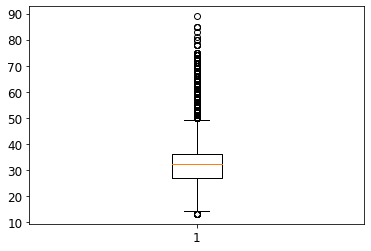

In [106]:
plt.boxplot(imputed_data.FAGECOMB)

In [107]:
q_FAGECOMB = imputed_data.FAGECOMB.quantile(0.997)

In [108]:
q_FAGECOMB

56.0

### Prenatal Visits

{'whiskers': [<matplotlib.lines.Line2D at 0x180070a4b20>,
 'caps': [<matplotlib.lines.Line2D at 0x180070b0220>,
 'boxes': [<matplotlib.lines.Line2D at 0x180070a47c0>],
 'medians': [<matplotlib.lines.Line2D at 0x180070b08e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x180070b0c40>],
 'means': []}

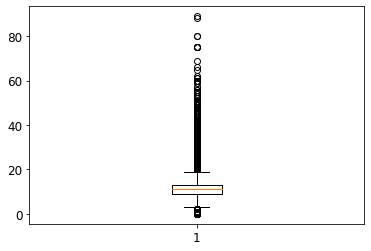

In [109]:
plt.boxplot(imputed_data.PREVIS)

In [110]:
q_PREVIS = imputed_data.PREVIS.quantile(0.997)
q_PREVIS

30.0

### Infant Birth Weight

{'whiskers': [<matplotlib.lines.Line2D at 0x180070fea90>,
 'caps': [<matplotlib.lines.Line2D at 0x1800710b190>,
 'boxes': [<matplotlib.lines.Line2D at 0x180070fe730>],
 'medians': [<matplotlib.lines.Line2D at 0x1800710b850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1800710bbb0>],
 'means': []}

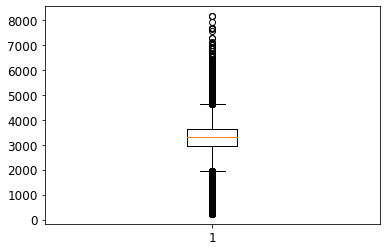

In [111]:
plt.boxplot(imputed_data.DBWT)

In [112]:
q_DBWT_high = imputed_data.DBWT.quantile(0.997)
q_DBWT_low = imputed_data.DBWT.quantile(0.003)
q_DBWT_high

4760.0

In [113]:
q_DBWT_low

680.0

In [123]:
imputed_data['DBWT'].loc[(imputed_data.DBWT < 4760) & (imputed_data.DBWT > 680)].count()

993941

## Final Cleaned and Encoded Data Set

In [ ]:
final_data = imputed_encoded_data[(imputed_encoded_data['FAGECOMB'] < q_FAGECOMB) & 
                                                     (imputed_encoded_data['PREVIS'] < q_PREVIS) & 
                                                     (imputed_encoded_data['DBWT'] > q_DBWT_low) & 
                                                     (imputed_encoded_data['DBWT'] < q_DBWT_high)]

In [ ]:
final_data.info()

In [ ]:
final_data.to_csv('final_data.csv')

In [131]:
final_data = pd.read_csv('final_data.csv')

In [179]:
final_data.head()

In [180]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 987629 entries, 0 to 987628
Columns: 102 entries, Unnamed: 0 to FEDUC_8.0
dtypes: float64(101), int64(1)
memory usage: 768.6 MB


## Split Data into Train and Test Sets

In [132]:
# split data into train_set (80%) and test_set (20%)
train_set, test_set = train_test_split(final_data, test_size=0.2, random_state=0)

In [133]:
#features training sets
X_paternal_train = train_set[['DMAR', 'FAGECOMB', 'FRACE31_2.0', 'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 
                              'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 'FRACE31_9.0', 'FRACE31_10.0', 
                              'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0', 'FRACE31_15.0', 
                              'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 'FRACE31_20.0', 
                              'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 'FRACE31_25.0',
                              'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 'FRACE31_30.0', 
                              'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

X_maternal_train = train_set[['DMAR', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 
                              'MRACE31_11.0', 'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 
                              'MRACE31_16.0', 'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0',
                              'MRACE31_21.0', 'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 
                              'MRACE31_26.0', 'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 
                              'MRACE31_31.0', 'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0',]]

X_combined_train = train_set[['DMAR', 'FAGECOMB', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 'MRACE31_11.0', 
                              'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 'MRACE31_16.0', 
                              'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0', 'MRACE31_21.0', 
                              'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 'MRACE31_26.0', 
                              'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 'MRACE31_31.0', 
                              'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0', 'FRACE31_2.0', 
                              'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 
                              'FRACE31_9.0', 'FRACE31_10.0', 'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0',
                              'FRACE31_15.0', 'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 
                              'FRACE31_20.0', 'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 
                              'FRACE31_25.0', 'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 
                              'FRACE31_30.0', 'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

# responses training sets 
y_clf_train = train_set[['WIC_R', 'TRIAL_R', 'DMETH_REC', 'BFED_R']]
y_reg_train = train_set[['PREVIS', 'DBWT', 'OEGEST_COMB']]

In [134]:
# features test sets 
X_paternal_test = test_set[['DMAR', 'FAGECOMB', 'FRACE31_2.0', 'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 
                              'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 'FRACE31_9.0', 'FRACE31_10.0', 
                              'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0', 'FRACE31_15.0', 
                              'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 'FRACE31_20.0', 
                              'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 'FRACE31_25.0',
                              'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 'FRACE31_30.0', 
                              'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

X_maternal_test = test_set[['DMAR', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 
                              'MRACE31_11.0', 'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 
                              'MRACE31_16.0', 'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0',
                              'MRACE31_21.0', 'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 
                              'MRACE31_26.0', 'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 
                              'MRACE31_31.0', 'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0',]]

X_combined_test = test_set[['DMAR', 'FAGECOMB', 'MAGER', 'MEDUC_2.0', 'MEDUC_3.0', 'MEDUC_4.0', 'MEDUC_5.0', 'MEDUC_6.0',
                              'MEDUC_7.0', 'MEDUC_8.0', 'MRACE31_2.0', 'MRACE31_3.0', 'MRACE31_4.0', 'MRACE31_5.0', 
                              'MRACE31_6.0', 'MRACE31_7.0', 'MRACE31_8.0', 'MRACE31_9.0', 'MRACE31_10.0', 'MRACE31_11.0', 
                              'MRACE31_12.0', 'MRACE31_13.0', 'MRACE31_14.0', 'MRACE31_15.0', 'MRACE31_16.0', 
                              'MRACE31_17.0', 'MRACE31_18.0', 'MRACE31_19.0', 'MRACE31_20.0', 'MRACE31_21.0', 
                              'MRACE31_22.0', 'MRACE31_23.0', 'MRACE31_24.0', 'MRACE31_25.0', 'MRACE31_26.0', 
                              'MRACE31_27.0', 'MRACE31_28.0', 'MRACE31_29.0', 'MRACE31_30.0', 'MRACE31_31.0', 
                              'MHISP_R_1.0', 'MHISP_R_2.0', 'MHISP_R_3.0', 'MHISP_R_4.0', 'MHISP_R_5.0', 'FRACE31_2.0', 
                              'FRACE31_3.0', 'FRACE31_4.0', 'FRACE31_5.0', 'FRACE31_6.0', 'FRACE31_7.0', 'FRACE31_8.0', 
                              'FRACE31_9.0', 'FRACE31_10.0', 'FRACE31_11.0', 'FRACE31_12.0', 'FRACE31_13.0', 'FRACE31_14.0',
                              'FRACE31_15.0', 'FRACE31_16.0', 'FRACE31_17.0', 'FRACE31_18.0', 'FRACE31_19.0', 
                              'FRACE31_20.0', 'FRACE31_21.0', 'FRACE31_22.0', 'FRACE31_23.0', 'FRACE31_24.0', 
                              'FRACE31_25.0', 'FRACE31_26.0', 'FRACE31_27.0', 'FRACE31_28.0', 'FRACE31_29.0', 
                              'FRACE31_30.0', 'FRACE31_31.0', 'FHISP_R_1.0', 'FHISP_R_2.0', 'FHISP_R_3.0', 'FHISP_R_4.0', 
                              'FHISP_R_5.0', 'FEDUC_2.0', 'FEDUC_3.0', 'FEDUC_4.0', 'FEDUC_5.0', 'FEDUC_6.0', 
                              'FEDUC_7.0', 'FEDUC_8.0']]

# responses test sets
y_clf_test = test_set[['WIC_R', 'TRIAL_R', 'DMETH_REC', 'BFED_R']]
y_reg_test = test_set[['PREVIS', 'DBWT', 'OEGEST_COMB']]

In [ ]:
train_set.info()

In [ ]:
test_set.info()

## Hyperparameter Tuning for MultiOutputClassifier RandomForestClassifier Models

### Paternal Features

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
clf_model = MultiOutputClassifier(estimator=rf_clf)

In [ ]:
# Coarse MultiOutputClassifier RandomClassifier GridSearch - paternal

param_grid_coarse_paternal = {'estimator__max_depth':[2, 4, 5, 10, 15],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 10, 15]}

gscv_paternal_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_coarse.fit(X_paternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_paternal_clf_coarse.best_params_)

Returned: The best coarse parameters are: estimator__max_depth = 10, estimator__n_estimators = 250, estimator__min_samples_split = 3

In [ ]:
# Refined MultiOutputClassifier RandomForestClassifier GridSearch - paternal

param_grid_refined_paternal = {'estimator__max_depth':[6, 8, 10, 12, 14], 
              'estimator__n_estimators': [150, 250, 350], 
              'estimator__min_samples_split': [2, 3, 4]}

gscv_paternal_clf_refined = GridSearchCV(clf_model, param_grid_refined_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_refined.fit(X_paternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_paternal_clf_refined.best_params_)

Returned: The best refined parameters are: estimator__max_depth = 14, estimator__n_estimators = 250, estimator__min_samples_split = 2

In [39]:
# Final MultiOutputClassifier RandomForestClassifier GridSearch - paternal
param_grid_final_paternal = {'estimator__max_depth':[13, 14, 15], 
              'estimator__n_estimators': [250], 
              'estimator__min_samples_split': [2]}

gscv_paternal_clf_final = GridSearchCV(clf_model, param_grid_final_paternal, n_jobs=-1, cv=3)
gscv_paternal_clf_final.fit(X_paternal_train, y_clf_train)

print("The best final parameters are: ", gscv_paternal_clf_final.best_params_)

Returned: The best final parameters are: estimator__max_depth = 14, estimator__n_estimators = 250, estimator__min_samples_split = 3

### Maternal Features 

In [37]:
# Coarse MultiOutputClassifier RandomClassifier GridSearch - maternal
param_grid_coarse_maternal = {'estimator__max_depth':[8,12,16],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7]}

gscv_maternal_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_coarse.fit(X_maternal_train, y_clf_train)

print("The best coarse parameters are: ", gscv_maternal_clf_coarse.best_params_)

The best coarse parameters are:  {'estimator__max_depth': 12, 'estimator__min_samples_split': 7, 'estimator__n_estimators': 250}


In [ ]:
# Refined MultiOutputClassifier RandomForestClassifier GridSearch - maternal

param_grid_refined_maternal = {'estimator__max_depth':[10, 12, 14], 
              'estimator__n_estimators': [150, 250, 350], 
              'estimator__min_samples_split': [7, 9, 11]}

gscv_maternal_clf_refined = GridSearchCV(clf_model, param_grid_refined_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_refined.fit(X_maternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_maternal_clf_refined.best_params_)

Returned: The best refined parameters are: estimator__max_depth = 12, estimator__n_estimators = 150, estimator__min_samples_split = 9

In [ ]:
# Final MultiOutputClassifier RandomForestClassifier GridSearch - maternal

param_grid_final_maternal = {'estimator__max_depth':[11, 12, 13], 
              'estimator__n_estimators': [100, 150, 200], 
              'estimator__min_samples_split': [8, 9, 10]}

gscv_maternal_clf_final = GridSearchCV(clf_model, param_grid_final_maternal, n_jobs=-1, cv=3)
gscv_maternal_clf_final.fit(X_maternal_train, y_clf_train)

print("The best refined parameters are: ", gscv_maternal_clf_final.best_params_)

Returned: The best final parameters are: estimator__max_depth = 12, estimator__n_estimators = 150, estimator__min_samples_split = 10

### Combined Paternal and Maternal Features

In [46]:
# Coarse MultiOutputClassifier RandomClassifier GridSearch - combined
param_grid_coarse_combined = {'estimator__max_depth':[8, 12, 16],
              'estimator__n_estimators':[250, 500, 750, 1000],
              'estimator__min_samples_split':[3, 5, 7]}

gscv_combined_clf_coarse = GridSearchCV(clf_model, param_grid_coarse_combined, n_jobs=-1, cv=3)
gscv_combined_clf_coarse.fit(X_combined_train, y_clf_train)

print("The best coarse parameters are: ", gscv_combined_clf_coarse.best_params_)

The best coarse parameters are:  {'estimator__max_depth': 16, 'estimator__min_samples_split': 3, 'estimator__n_estimators': 250}


In [47]:
# Refined MultiOutputClassifier RandomForestClassifier GridSearch - combined

param_grid_refined_combined = {'estimator__max_depth':[14, 16, 18], 
              'estimator__n_estimators': [150, 250, 350], 
              'estimator__min_samples_split': [2, 3, 4]}

gscv_combined_clf_refined = GridSearchCV(clf_model, param_grid_refined_combined, n_jobs=-1, cv=3)
gscv_combined_clf_refined.fit(X_combined_train, y_clf_train)

print("The best refined parameters are: ", gscv_combined_clf_refined.best_params_)

The best refined parameters are:  {'estimator__max_depth': 16, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 350}


In [50]:
# Final MultiOutputClassifier RandomForestClassifier GridSearch - combined
param_grid_final_combined = {'estimator__max_depth':[15,16,17], 
              'estimator__n_estimators': [300, 350, 400], 
              'estimator__min_samples_split': [4]}

gscv_combined_clf_final = GridSearchCV(clf_model, param_grid_final_combined, n_jobs=-1, cv=3)
gscv_combined_clf_final.fit(X_combined_train, y_clf_train)

print("The best refined parameters are: ", gscv_combined_clf_final.best_params_)

The best refined parameters are:  {'estimator__max_depth': 17, 'estimator__min_samples_split': 4, 'estimator__n_estimators': 350}


## MultiOutputClassifier RandomForestClassifier Models

### Paternal Models

In [ ]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
clf_model = MultiOutputClassifier(estimator=rf_clf)

In [ ]:
# MultiOutputClassifier RandomForestClassifier model on paternal features using default hyperparameter values
rf_clf_paternal = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_paternal.fit(X_paternal_train, y_clf_train)

In [ ]:
# predict responses based on the default paternal MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_paternal = rf_clf_paternal.predict(X_paternal_test)
y_pred_rf_clf_paternal

In [ ]:
# Optimal MultiOutputClassifier RandomForestClassifier Model based on GridSearch results for paternal features - hard coded to reduce need to run GridSearchCV again
optimal_rf_clf_paternal = MultiOutputClassifier(RandomForestClassifier(max_depth=14, n_estimators=250, min_samples_split=2, random_state=42)).fit(X_paternal_train, y_clf_train)

In [ ]:
# Pickle model
joblib.dump(optimal_rf_clf_paternal, 'clf_paternal_model.pkl')

In [ ]:
# Load pickle model
optimal_rf_clf_paternal = joblib.load('clf_paternal_model.pkl')

In [ ]:
#predict responses based on the paternal MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_paternal = optimal_rf_clf_paternal.predict(X_paternal_test)
y_pred_rf_clf_paternal

### Maternal Models

In [ ]:
# MultiOutputClassifier RandomForestClassifier model on maternal features using default hyperparameter values
rf_clf_maternal = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_maternal.fit(X_maternal_train, y_clf_train)

In [ ]:
# predict responses based on the default maternal MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_maternal = rf_clf_maternal.predict(X_maternal_test)
y_pred_rf_clf_maternal

In [ ]:
# Optimal MultiOutputClassifier RandomForestClassifier Model based on GridSearch results for maternal features - hard coded to reduce need to run GridSearchCV again
optimal_rf_clf_maternal = MultiOutputClassifier(RandomForestClassifier(max_depth=12, n_estimators=150, min_samples_split=10, random_state=42)).fit(X_maternal_train, y_clf_train)

In [ ]:
# Pickle model
joblib.dump(optimal_rf_clf_maternal, 'clf_maternal_model.pkl')

In [ ]:
# Load pickle model
optimal_rf_clf_maternal = joblib.load('clf_maternal_model.pkl')

In [ ]:
#predict responses based on the maternal MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_maternal = optimal_rf_clf_maternal.predict(X_maternal_test)
y_pred_rf_clf_maternal

### Combined Models

In [ ]:
# MultiOutputClassifier RandomForestClassifier model on combined paternal and maternal features using default hyperparameter values
rf_clf_combined = MultiOutputClassifier(RandomForestClassifier(max_depth=20, random_state=42))
rf_clf_combined.fit(X_combined_train, y_clf_train)

In [ ]:
# predict responses based on the default combined MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_combined = rf_clf_combined.predict(X_combined_test)
y_pred_rf_clf_combined

In [ ]:
# Optimal MultiOutputClassifier RandomForestClassifier Model based on GridSearch results for combined paternal and maternal features - hard coded to reduce need to run GridSearchCV again
optimal_rf_clf_combined = MultiOutputClassifier(RandomForestClassifier(max_depth=17, n_estimators=350, min_samples_split=4, random_state=42)).fit(X_combined_train, y_clf_train)

In [ ]:
# Pickle model
joblib.dump(optimal_rf_clf_combined, 'clf_combined_model.pkl')

In [ ]:
# Load pickle model
optimal_rf_clf_combined = joblib.load('clf_combined_model.pkl')

In [ ]:
#predict responses based on the combined paternal and maternal MultiOutputClassifier RandomForestClassifier model
y_pred_rf_clf_combined = optimal_rf_clf_combined.predict(X_combined_test)
y_pred_rf_clf_combined

## Confusion Matrices for MultiOutputClassifier RandomForestClassifier Models

Confusion matrices were run to examine how well the models accurately predicted the correct classification for each target variable.  Results of the confusion matrices show that effectiveness of each model in accurately classifying cases was similar.  The maternal features model and combined features model made correct classifications of whether a family used WIC benefits 74% of the time while the paternal features model was correct 73% of the time.  All three models were correct 77% of the time when classifying whether or not a trial of labor was attempted.  Similarly, the three models correctly classified the delivery method 68% of the time.  Classification of breastfeeding at discharge was slightly better than the other targets, with all three models correct about 83% of the time.



### Paternal Classification Model

In [ ]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_paternal_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_paternal_optimal[:,0])
cm_clf_paternal_wic

In [ ]:
disp_clf_paternal_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_wic)
disp_clf_paternal_wic.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_paternal_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_paternal_optimal[:,1])
cm_clf_paternal_trial

In [ ]:
disp_clf_paternal_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_trial)
disp_clf_paternal_trial.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not delivery was vaginal
cm_clf_paternal_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_paternal_optimal[:,2])
cm_clf_paternal_delivery

In [ ]:
disp_clf_paternal_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_delivery)
disp_clf_paternal_delivery.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of paternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_paternal_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_paternal_optimal[:,3])
cm_clf_paternal_bfed

In [ ]:
disp_clf_paternal_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_paternal_bfed)
disp_clf_paternal_bfed.plot()
plt.show()

### Maternal Classification Model

In [ ]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_maternal_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_maternal_optimal[:,0])
cm_clf_maternal_wic

In [ ]:
disp_clf_maternal_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_wic)
disp_clf_maternal_wic.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_maternal_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_maternal_optimal[:,1])
cm_clf_maternal_trial

In [ ]:
disp_clf_maternal_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_trial)
disp_clf_maternal_trial.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not delivery was vaginal
cm_clf_maternal_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_maternal_optimal[:,2])
cm_clf_maternal_delivery

In [ ]:
disp_clf_maternal_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_delivery)
disp_clf_maternal_delivery.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of maternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_maternal_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_maternal_optimal[:,3])
cm_clf_maternal_bfed

In [ ]:
disp_clf_maternal_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_maternal_bfed)
disp_clf_maternal_bfed.plot()
plt.show()

### Combined Paternal and Maternal Classificiation Model

In [ ]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not a woman received WIC benefits during pregnancy
cm_clf_combined_wic = confusion_matrix(y_clf_test.iloc[:,0], y_pred_rf_clf_combined_optimal[:,0])
cm_clf_combined_wic

In [ ]:
disp_clf_combined_wic = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_wic)
disp_clf_combined_wic.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not vaginal delivery was attempted prior to cesarean 
cm_clf_combined_trial = confusion_matrix(y_clf_test.iloc[:,1], y_pred_rf_clf_combined_optimal[:,1])
cm_clf_combined_trial

In [ ]:
disp_clf_combined_trial = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_trial)
disp_clf_combined_trial.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not delivery was vaginal
cm_clf_combined_delivery = confusion_matrix(y_clf_test.iloc[:,2], y_pred_rf_clf_combined_optimal[:,2])
cm_clf_combined_delivery

In [ ]:
disp_clf_combined_delivery = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_delivery)
disp_clf_combined_delivery.plot()
plt.show()

In [ ]:
# Confusion matrix demonstrating accuracy of combined paternal and maternal features at predicting whether or not the infant was breastfed at discharge
cm_clf_combined_bfed = confusion_matrix(y_clf_test.iloc[:,3], y_pred_rf_clf_combined_optimal[:,3])
cm_clf_combined_bfed

In [ ]:
disp_clf_combined_bfed = ConfusionMatrixDisplay(confusion_matrix=cm_clf_combined_bfed)
disp_clf_combined_bfed.plot()
plt.show()

## Permutation Importance for MultiOutputClassifier RandomForestClassifier Models

For both the maternal and paternal classification models, marital status and age were the two features that were the most important to the model.  Both models also included being of Mexican descent, having a Bachelor's degree, and having attended at least some high school without graduating in the top five features.  Marital status was the most important feature for the combined classification model.  The other most important features included the parents having Bachelor's degrees and being of Mexican descent, consistent with the findings of the individual paternal and maternal models.

### Paternal Model

In [ ]:
# permutation importance for paternal MultiOutputClassifier RandomForestClassifier Model
r_clf_paternal = permutation_importance(rf_clf_paternal, X_paternal_test, y_clf_test, n_repeats=10, random_state=42)

In [ ]:
# Pickle file
joblib.dump(r_clf_paternal, 'pi_clf_paternal.pkl')

In [128]:
# Load pickle file
r_clf_paternal = joblib.load('pi_clf_paternal.pkl')

In [129]:
# sort and prep permutation importances for graphs
sorted_importances_idx_clf_paternal = r_clf_paternal.importances_mean.argsort()

In [136]:
importances_clf_paternal = pd.DataFrame(r_clf_paternal.importances[sorted_importances_idx_clf_paternal].T, columns=X_paternal_test.columns[sorted_importances_idx_clf_paternal])

In [137]:
top_importances_clf_paternal = pd.DataFrame(r_clf_paternal.importances[sorted_importances_idx_clf_paternal].T, columns=X_paternal_test.columns[sorted_importances_idx_clf_paternal]).iloc[:, -10:]

Text(0.5, 1.0, 'Permutation Importances for Features of the Paternal Classification Model')

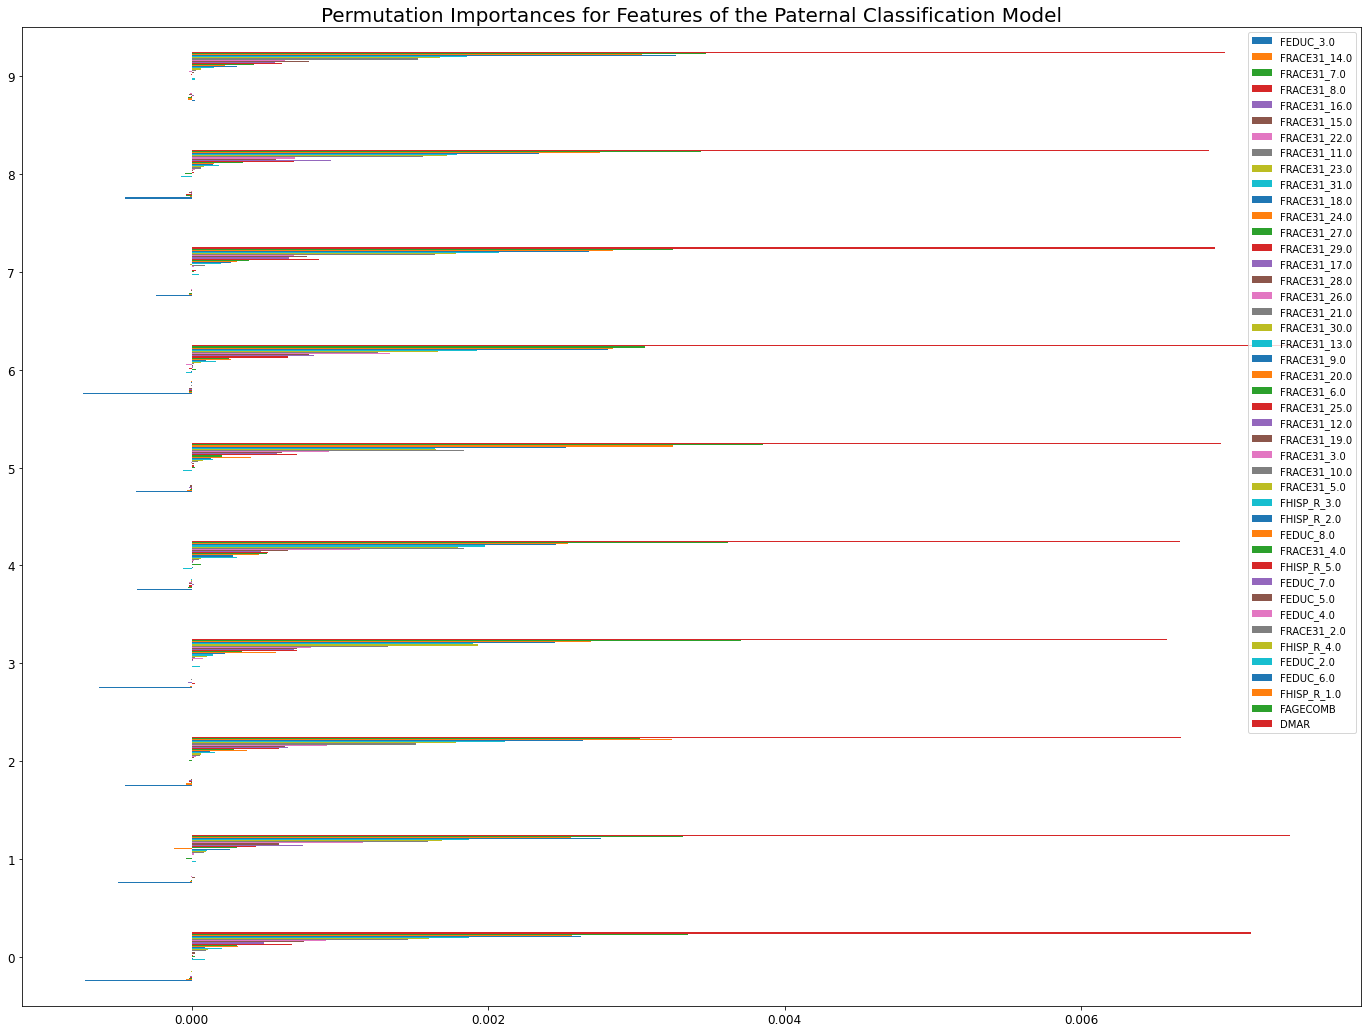

In [138]:
# Graph permutation importance features for paternal model
ax_clf_paternal = importances_clf_paternal.plot.barh(figsize=(24, 18))
ax_clf_paternal.set_title('Permutation Importances for Features of the Paternal Classification Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Paternal Classification Model')

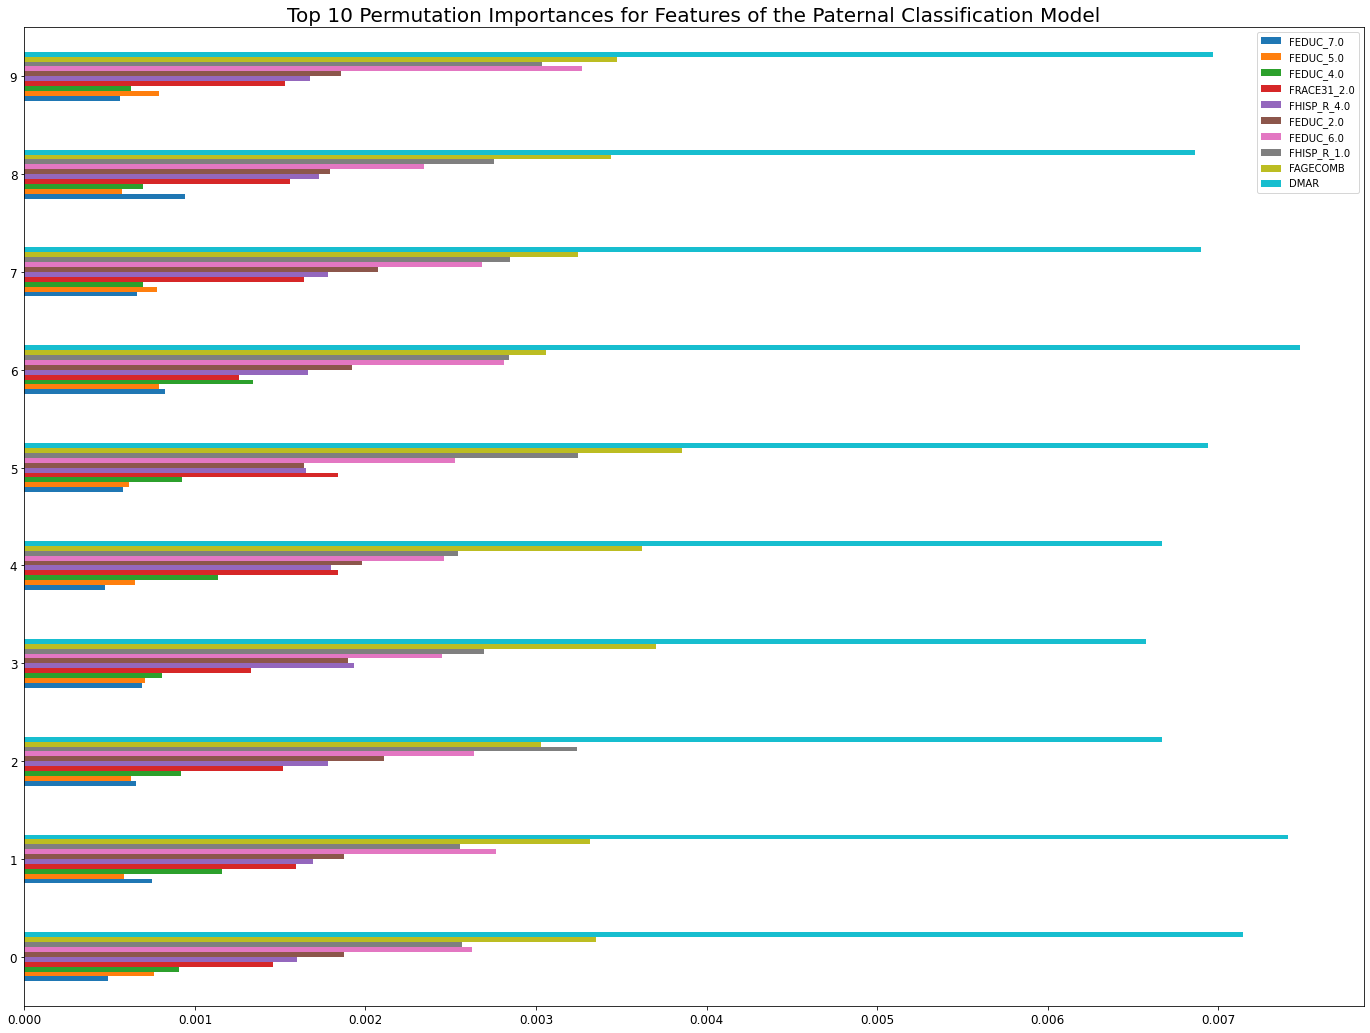

In [139]:
# Graph 10 most important features for paternal model
top_ax_clf_paternal = top_importances_clf_paternal.plot.barh(figsize=(24, 18))
top_ax_clf_paternal.set_title('Top 10 Permutation Importances for Features of the Paternal Classification Model')

In [ ]:
r_clf_paternal.importances_mean

In [ ]:
r_clf_paternal.importances

### Maternal Model

In [ ]:
# permutation importance for maternal MultiOutputClassifier RandomForestClassifier Model
r_clf_maternal = permutation_importance(rf_clf_maternal, X_maternal_test, y_clf_test, n_repeats=10, random_state=42)

In [ ]:
# Pickle file
joblib.dump(r_clf_maternal, 'pi_clf_maternal.pkl')

In [140]:
# Load pickle file
r_clf_maternal = joblib.load('pi_clf_maternal.pkl')

In [141]:
# sort and prep permutation importances for graphs
sorted_importances_idx_clf_maternal = r_clf_maternal.importances_mean.argsort()

In [ ]:
importances_clf_maternal = pd.DataFrame(r_clf_maternal.importances[sorted_importances_idx_clf_maternal].T, columns=X_maternal_test.columns[sorted_importances_idx_clf_maternal])

In [142]:
top_importances_clf_maternal = pd.DataFrame(r_clf_maternal.importances[sorted_importances_idx_clf_maternal].T, columns=X_maternal_test.columns[sorted_importances_idx_clf_maternal]).iloc[:, -10:]

In [ ]:
# Graph permutation importance features for combined model
ax_clf_maternal = importances_clf_maternal.plot.barh(figsize=(24, 18))
ax_clf_maternal.set_title('Permutation Importances for Features of the Maternal Classification Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Maternal Classification Model')

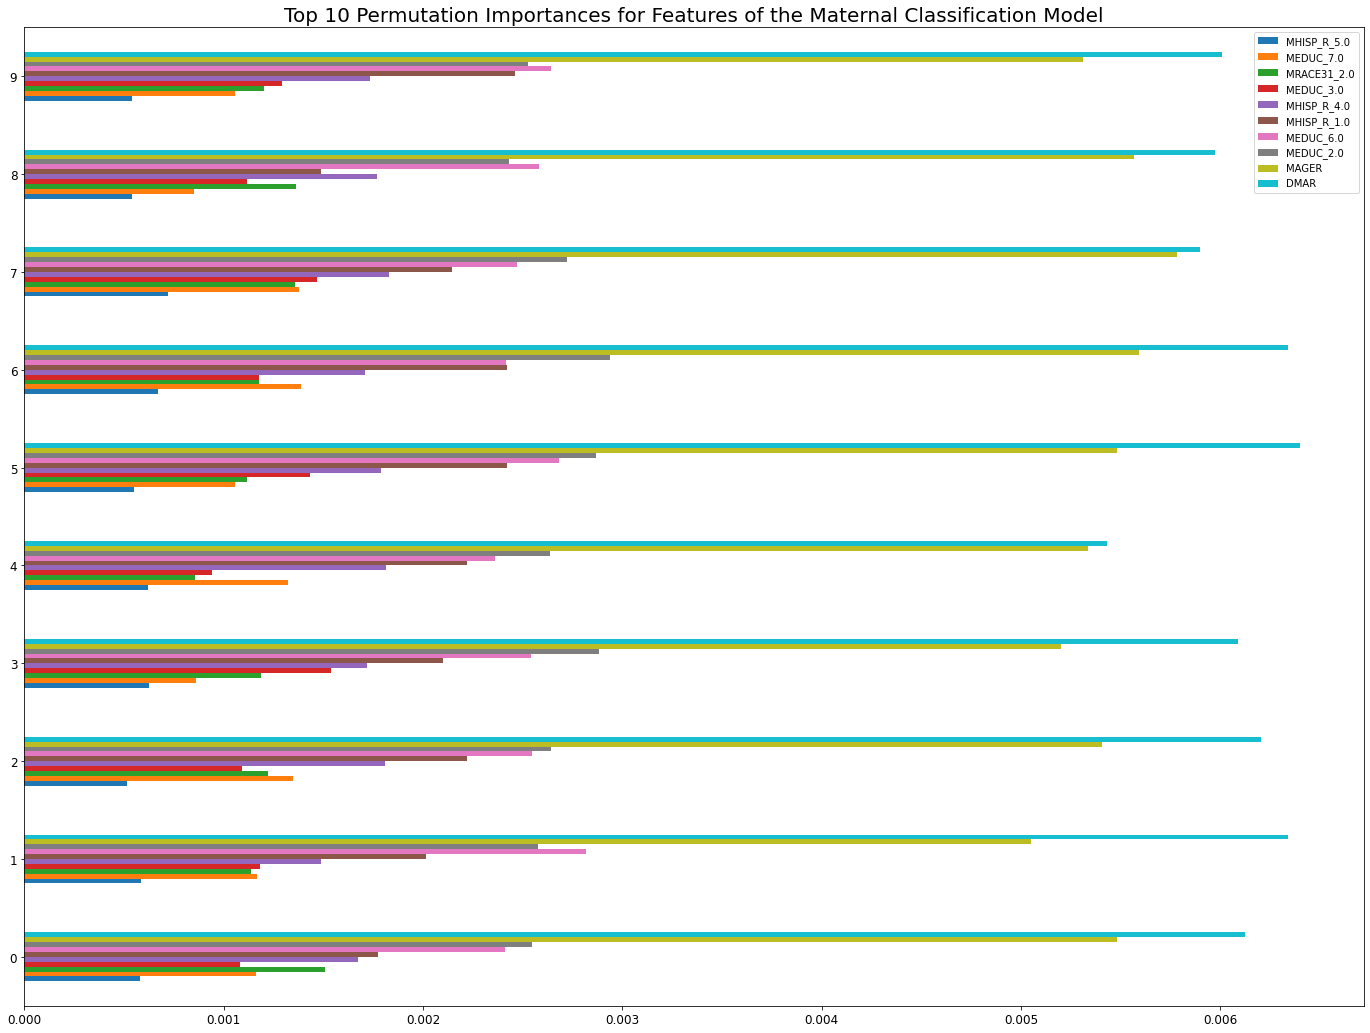

In [143]:
# Graph 10 most important features for maternal model
top_ax_clf_maternal = top_importances_clf_maternal.plot.barh(figsize=(24, 18))
top_ax_clf_maternal.set_title('Top 10 Permutation Importances for Features of the Maternal Classification Model')

In [ ]:
r_clf_maternal.importances_mean

In [ ]:
r_clf_maternal.importances

### Combined Model

In [8]:
# permutation importance for combined MultiOutputClassifier RandomForestClassifier Model
r_clf_combined = permutation_importance(optimal_rf_clf_combined, X_combined_test, y_clf_test, n_repeats=5, random_state=42)

In [9]:
# Pickle file
joblib.dump(r_clf_combined, 'pi_clf_combined.pkl')

['pi_clf_combined.pkl']

In [147]:
# Load pickle file
r_clf_combined = joblib.load('pi_clf_combined.pkl')

In [148]:
# sort and prep permutation importances for graphs
sorted_importances_idx_clf_combined = r_clf_combined.importances_mean.argsort()

In [11]:
importances_clf_combined = pd.DataFrame(r_clf_combined.importances[sorted_importances_idx_clf_combined].T, 
                                        columns=X_combined_test.columns[sorted_importances_idx_clf_combined])

In [149]:
top_importances_clf_combined = pd.DataFrame(r_clf_combined.importances[sorted_importances_idx_clf_combined].T, 
                                            columns=X_combined_test.columns[sorted_importances_idx_clf_combined]).iloc[:, -10:]

In [150]:
# Graph permutation importance features for combined model
ax_clf_combined = importances_clf_combined.plot.barh(figsize=(24, 18))
ax_clf_combined.set_title('Permutation Importances for Features of the Combined Classification Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Combined Classification Model')

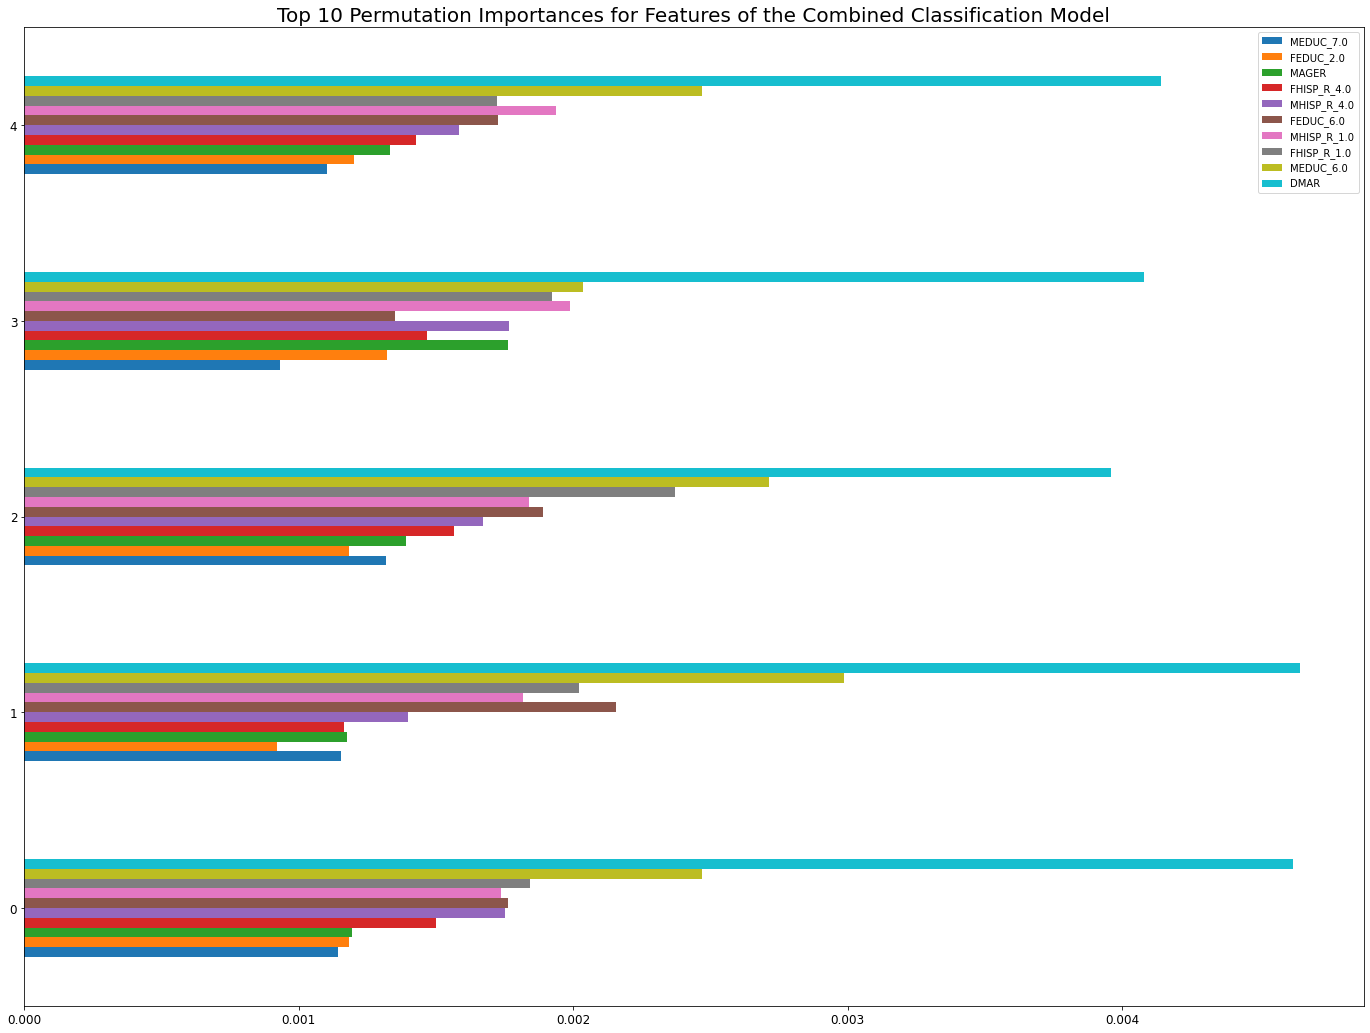

In [151]:
# Graph 10 most important features for combined model
top_ax_clf_combined = top_importances_clf_combined.plot.barh(figsize=(24, 18))
top_ax_clf_combined.set_title('Top 10 Permutation Importances for Features of the Combined Classification Model')

In [152]:
r_clf_combined.importances_mean

In [153]:
r_clf_combined.importances

## Accuracy, Precision, Recall, and F1 Scores for MultiOutputClassifier RandomForestClassifier Models

### Accuracy

In [155]:
# MultiOutputClassifier RandomForestClassifier accuracy of default paternal model
rf_paternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_paternal)
rf_paternal_accuracy

In [ ]:
# MultiOutputClassifier RandomForestClassifier accuracy of optimal paternal model
optimal_rf_paternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_paternal_optimal)
optimal_rf_paternal_accuracy

In [ ]:
# MultiOutputClassifier RandomForestClassifier accuracy of default maternal model
rf_maternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_maternal)
rf_maternal_accuracy

In [ ]:
# MultiOutputClassifier RandomForestClassifier accuracy of optimal maternal model
optimal_rf_maternal_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_maternal_optimal)
optimal_rf_maternal_accuracy

In [ ]:
# MultiOutputClassifier RandomForestClassifier accuracy of default combined model
rf_combined_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_combined)
rf_combined_accuracy

In [ ]:
# MultiOutputClassifier RandomForestClassifier accuracy of optimal combined model
optimal_rf_combined_accuracy = accuracy_score(y_clf_test, y_pred_rf_clf_combined_optimal)
optimal_rf_combined_accuracy

### Precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of default paternal model
rf_paternal_precision = precision_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of optimal paternal model
optimal_rf_paternal_precision = precision_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of default maternal model
rf_maternal_precision = precision_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of optimal maternal model
optimal_rf_maternal_precision = precision_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of default combined model
rf_combined_precision = precision_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_precision

In [ ]:
# MultiOutputClassifier RandomForestClassifier precision of optimal combined model
optimal_rf_combined_precision = precision_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_precision

### Recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of default paternal model
rf_paternal_recall = recall_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of optimal paternal model
optimal_rf_paternal_recall = recall_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of default maternal model
rf_maternal_recall = recall_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of optimal maternal model
optimal_rf_maternal_recall = recall_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of default combined model
rf_combined_recall = recall_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_recall

In [ ]:
# MultiOutputClassifier RandomForestClassifier recall of optimal combined model
optimal_rf_combined_recall = recall_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_recall

### F1 Score

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of default paternal model
rf_paternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_paternal, average='micro')
rf_paternal_f1

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of optimal paternal model
optimal_rf_paternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_paternal_optimal, average='micro')
optimal_rf_paternal_f1

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of default maternal model
rf_maternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_maternal, average='micro')
rf_maternal_f1

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of optimal maternal model
optimal_rf_maternal_f1 = f1_score(y_clf_test, y_pred_rf_clf_maternal_optimal, average='micro')
optimal_rf_maternal_f1

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of default combined model
rf_combined_f1 = f1_score(y_clf_test, y_pred_rf_clf_combined, average='micro')
rf_combined_f1

In [ ]:
# MultiOutputClassifier RandomForestClassifier F1 scores of optimal combined model
optimal_rf_combined_f1 = f1_score(y_clf_test, y_pred_rf_clf_combined_optimal, average='micro')
optimal_rf_combined_f1

## Summary Results of the MultiOutputClassifier RandomForestClassifier Models

Consistent with results reported by Meinert (2019), the optimized classification models showed only small improvements over the default classification models.  Accuracy and Precision scores were slightly higher for the optimized models, whereas Recall and F1 scores were slightly higher for the default models, but all differences were small.

Accuracy scores for all three classification models were likely low because the dataset was skewed with regards to the target values.  Specifically, the number of families that received WIC benefits, the number of women who had a trial of labor before a cesarean, the number of babies delivered by cesarean were disproportionately small, and a disproportionate majority of infants were breastfed at discharge.

In general, the classification model using maternal demographic features had better accuracy and precision than the model using paternal demographic features, but the paternal model had better recall, and the F1 scores for both were the same.  Combining both sets of features resulted in slightly better accuracy, recall, and F1 scores, while the precision score was almost the same as that of the maternal model.

## Hyperparameter Tuning for MultiOutputRegressor RandomForestRegressor Models

In [8]:
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=6, min_samples_split=2, random_state=42)
reg_model = MultiOutputRegressor(estimator=rf_reg)

#### Paternal Features Model

In [52]:
# Coarse-Grained MultiOutputRegressor RandomForestRegressor GridSearch - paternal

param_grid_coarse_reg_paternal = {'estimator__max_depth':[8, 12, 16], 
              'estimator__n_estimators': [250, 500, 750, 1000], 
              'estimator__min_samples_split': [3,5,7]}

gscv_paternal_reg_coarse = GridSearchCV(reg_model, param_grid_coarse_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_coarse.fit(X_paternal_train, y_reg_train)

print("The best parameters are: ", gscv_paternal_reg_coarse.best_params_)

The best parameters are:  {'estimator__max_depth': 12, 'estimator__min_samples_split': 7, 'estimator__n_estimators': 250}


In [53]:
# Refined MultiOutputRegressor RandomForestRegressor GridSearch - paternal

param_grid_refined_reg_paternal = {'estimator__max_depth':[10, 12, 14], 
              'estimator__n_estimators': [150, 250, 350], 
              'estimator__min_samples_split': [6, 7, 9]}

gscv_paternal_reg_refined = GridSearchCV(reg_model, param_grid_refined_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_refined.fit(X_paternal_train, y_reg_train)

print("The best parameters are: ", gscv_paternal_reg_refined.best_params_)

The best parameters are:  {'estimator__max_depth': 12, 'estimator__min_samples_split': 9, 'estimator__n_estimators': 350}


In [ ]:
# Final MultiOutputRegressor RandomForestRegressor GridSearch - paternal

param_grid_final_reg_paternal = {'estimator__max_depth':[11, 12, 13], 
              'estimator__n_estimators': [300, 350, 400, 450]}

gscv_paternal_reg_final = GridSearchCV(reg_model, param_grid_final_reg_paternal, n_jobs=-1, cv=3)
gscv_paternal_reg_final.fit(X_paternal_train, y_reg_train)

print("The best parameters are: ", gscv_paternal_reg_final.best_params_)

Ran gscv_paternal_reg_final several times trying to find the best min_samples_split value, but was always the highest option.  Went as high as 38 and then had to stop because was running out of time (each taking at least 12 hours to run) so decided to remove min_samples_split from regressor GridSearchCVs and use the default value.

Returned The best parameters are: {'estimator__max_depth': 12, 'estimator__n_estimators': 350}

#### Maternal Features Model

Switched to RandomizedSearchCV to see if it would run more quickly.  Still took a long time and had the same issue with min_samples_split so eventually used default min_samples_split.  Received a warning when running fewer than 10 iterations, so resorted to GridSearchCV for final analysis as recommended in warning.

In [61]:
# Coarse-Grained MultiOutputRegressor RandomForestRegressor RandomizedSearch - maternal

param_grid_coarse_reg_maternal = {'estimator__max_depth':[8, 12,16], 
              'estimator__n_estimators': [250, 500], 
              'estimator__min_samples_split': [3,5,7]}

rscv_maternal_reg_coarse = RandomizedSearchCV(reg_model, param_grid_coarse_reg_maternal, n_jobs=-1, cv=3)
rscv_maternal_reg_coarse.fit(X_maternal_train, y_reg_train)

print("The best parameters are: ", rscv_maternal_reg_coarse.best_params_)

The best parameters are:  {'estimator__n_estimators': 500, 'estimator__min_samples_split': 7, 'estimator__max_depth': 12}


In [66]:
# Refined MultiOutputRegressor RandomForestRegressor RandomizedSearch - maternal

param_grid_refined_reg_maternal = {'estimator__max_depth':[10, 12, 14], 
              'estimator__n_estimators': [500, 750], 
              'estimator__min_samples_split': [7, 12, 17]}

rscv_maternal_reg_refined = RandomizedSearchCV(reg_model, param_grid_refined_reg_maternal, n_jobs=-1, cv=3)
rscv_maternal_reg_refined.fit(X_maternal_train, y_reg_train)

print("The best parameters are: ", rscv_maternal_reg_refined.best_params_)

The best parameters are:  {'estimator__n_estimators': 750, 'estimator__min_samples_split': 17, 'estimator__max_depth': 12}


In [ ]:
# Final MultiOutputRegressor RandomForestRegressor GridSearch - maternal

param_grid_final_reg_maternal = {'estimator__max_depth':[11, 12, 13], 
              'estimator__n_estimators': [750, 850, 950, 1050]}

gscv_maternal_reg_final = GridSearchCV(reg_model, param_grid_final_reg_maternal, n_jobs=-1, cv=3)
gscv_maternal_reg_final.fit(X_maternal_train, y_reg_train)

print("The best parameters are: ", gscv_maternal_reg_final.best_params_)

Returned The best parameters are: {'estimator__max_depth': 12, 'estimator__n_estimators': 950}

#### Combined Paternal and Maternal Features Model

In [63]:
# Coarse-Grained MultiOutputRegressor RandomForestRegressor RandomizedSearch - combined

param_grid_coarse_reg_combined = {'estimator__max_depth':[12, 16, 20], 
              'estimator__n_estimators': [250, 500], 
              'estimator__min_samples_split': [5, 10, 15]}

rscv_combined_reg_coarse = RandomizedSearchCV(reg_model, param_grid_coarse_reg_combined, n_jobs=-1, cv=3)
rscv_combined_reg_coarse.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", rscv_combined_reg_coarse.best_params_)

The best parameters are:  {'estimator__n_estimators': 500, 'estimator__min_samples_split': 15, 'estimator__max_depth': 16}


In [ ]:
# Refined MultiOutputRegressor RandomForestRegressor GridSearch - combined

param_grid_refined_reg_combined = {'estimator__max_depth':[14, 16, 18], 
              'estimator__n_estimators': [400, 500, 750, 1000]}

gscv_combined_reg_refined = GridSearchCV(reg_model, param_grid_refined_reg_combined, n_jobs=-1, cv=3)
gscv_combined_reg_refined.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", gscv_combined_reg_refined.best_params_)

Returned The best parameters are: {'estimator__max_depth': 14, 'estimator__n_estimators': 1000}

In [ ]:
# Final MultiOutputRegressor RandomForestRegressor GridSearch - combined

param_grid_final_reg_combined = {'estimator__max_depth':[13, 14, 15], 
              'estimator__n_estimators': [800, 900, 1000, 1100]}

rscv_combined_reg_final = GridSearchCV(reg_model, param_grid_final_reg_combined, n_jobs=-1, cv=3)
rscv_combined_reg_final.fit(X_combined_train, y_reg_train)

print("The best parameters are: ", rscv_combined_reg_final.best_params_)

Returned The best parameters are: {'estimator__max_depth': 13, 'estimator__n_estimators': 1000}

## MultiOutputRegressor RandomForestRegressor Models

### Paternal Model

In [ ]:
# MultiOutputRegressor RandomForestRegressor model on paternal features using default hyperparameter values
rf_reg_paternal = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_paternal_train, y_reg_train)

In [ ]:
#predict responses based on the paternal MultiOutputRegressor RandomForestRegressor model
y_pred_rf_reg_paternal = rf_reg_paternal.predict(X_paternal_test)
y_pred_rf_reg_paternal

In [ ]:
# Optimal MultiOutputRegressor RandomForestRegressor Model based on GridSearch results for paternal features - hard coded to reduce need to run GridSearchCV again
optimal_rf_reg_paternal = MultiOutputRegressor(RandomForestRegressor(max_depth=12, n_estimators=350, random_state=42)).fit(X_paternal_train, y_reg_train)

In [ ]:
# Pickle optimal paternal model
joblib.dump(optimal_rf_reg_paternal, 'reg_paternal_model.pkl')

In [181]:
# reload pickle file
optimal_rf_reg_paternal = joblib.load('reg_paternal_model.pkl')

### Maternal Model

In [ ]:
# MultiOutputRegressor RandomForestClassifier model on maternal features using default hyperparameter values
rf_reg_maternal = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_maternal_train, y_reg_train)

In [ ]:
#predict responses based on the maternal RandomForestRegressor model
y_pred_rf_reg_maternal = rf_reg_maternal.predict(X_maternal_test)
y_pred_rf_reg_maternal

In [ ]:
# Optimal MultiOutputRegressor RandomForestRegressor Model based on GridSearch results for maternal features - hard coded to reduce need to run RandomizedSearchCV again
optimal_rf_reg_maternal = MultiOutputRegressor(RandomForestRegressor(max_depth=12, n_estimators=950, random_state=42)).fit(X_maternal_train, y_reg_train)

In [ ]:
# Pickle optimal maternal model
joblib.dump(optimal_rf_reg_maternal, 'reg_maternal_model.pkl')

In [173]:
# reload pickle file
optimal_rf_reg_maternal = joblib.load('reg_maternal_model.pkl')

### Combined Model

In [ ]:
# MultiOutputRegressor RandomForestClassifier model on combined paternal and maternal features using default hyperparameter values
rf_reg_combined = MultiOutputRegressor(RandomForestRegressor(max_depth=20, random_state=42)).fit(X_combined_train, y_reg_train)

In [ ]:
#predict responses based on the combined MultiOutputRegressor RandomForestRegressor model
y_pred_rf_reg_combined = rf_reg_combined.predict(X_combined_test)
y_pred_rf_reg_combined

In [ ]:
# Optimal MultiOutputRegressor RandomForestRegressor Model based on GridSearch results for combined paternal and maternal features - hard coded to reduce need to run RandomizedSearchCV again
optimal_rf_reg_combined = MultiOutputRegressor(RandomForestRegressor(max_depth=13, n_estimators=1000, random_state=42)).fit(X_combined_train, y_reg_train)

In [ ]:
# Pickle optimal combined model
joblib.dump(optimal_rf_reg_combined, 'reg_combined_model.pkl')

In [174]:
# reload pickle file
optimal_rf_reg_combined = joblib.load('reg_combined_model.pkl')

## Generalization Error for MultiOutputRegressor RandomForestRegressor Models

In [ ]:
#generalization error default paternal MultiOutputRegressor RandomForestRegressor model
rf_reg_paternal_y_pred = rf_reg_paternal.predict(X_paternal_test)
mse_rf_reg_paternal = mean_squared_error(y_reg_test, rf_reg_paternal_y_pred)
mse_rf_reg_paternal

In [175]:
#generalization error optimal paternal MultiOutputRegressor RandomForestRegressor model
optimal_rf_reg_paternal_y_pred = optimal_rf_reg_paternal.predict(X_paternal_test)
optimal_mse_rf_reg_paternal = mean_squared_error(y_reg_test, optimal_rf_reg_paternal_y_pred)
optimal_mse_rf_reg_paternal

102267.73397776876

In [ ]:
#generalization error default maternal MultiOutputRegressor RandomForestRegressor model
rf_reg_maternal_y_pred = rf_reg_maternal.predict(X_maternal_test)
mse_rf_reg_maternal = mean_squared_error(y_reg_test, rf_reg_maternal_y_pred)
mse_rf_reg_maternal

In [176]:
#generalization error optimal maternal MultiOutputRegressor RandomForestRegressor model
optimal_rf_reg_maternal_y_pred = optimal_rf_reg_maternal.predict(X_maternal_test)
optimal_mse_rf_reg_maternal = mean_squared_error(y_reg_test, optimal_rf_reg_maternal_y_pred)
optimal_mse_rf_reg_maternal

101870.9797665844

In [ ]:
#generalization error default combined MultiOutputRegressor RandomForestRegressor model
rf_reg_combined_y_pred = rf_reg_combined.predict(X_combined_test)
mse_rf_reg_combined = mean_squared_error(y_reg_test, rf_reg_combined_y_pred)
mse_rf_reg_combined

In [177]:
#generalization error optimal combined MultiOutputRegressor RandomForestRegressor model
optimal_rf_reg_combined_y_pred = optimal_rf_reg_combined.predict(X_combined_test)
optimal_mse_rf_reg_combined = mean_squared_error(y_reg_test, optimal_rf_reg_combined_y_pred)
optimal_mse_rf_reg_combined

101445.77204746597

## Permutation Importance for MultiOutputRegressor RandomForestRegressor Models

While marital status continued to be an important feature in the paternal regression model, a father's race being Black was the most important feature.  Having a Bachelor's degree, having a high school diploma or GED, and age rounded out the top five features for the paternal regression model.  The most important features in the maternal regression model were similar to those for the paternal model, but with a different order of priority.  Having a Bachelor's degree was the most important feature, followed by mother's race being Black, having a Master's degree, age, and having some college credit but not a degree.  In the combined models, the most important features were almost all maternal characteristics, with mother's education level and age being seven of the ten most important features, along with mother's race being Black, father's age, and marital status.  Based on these results, paternal characteristics do not appear to contribute much to the prediction of the number of prenatal visits, the infant's birthweight, or gestational age and that maternal characteristics may be better predictors of these targets.

### Paternal Model

In [ ]:
# permutation importance for paternal RandomForestRegressor Model
r_reg_paternal = permutation_importance(rf_reg_paternal, X_paternal_test, y_reg_test, n_repeats=10, random_state=42)

In [ ]:
# create pickle file
joblib.dump(r_reg_paternal, 'pi_reg_paternal.pkl')

In [156]:
# reload pickle file
r_reg_paternal = joblib.load('pi_reg_paternal.pkl')

In [157]:
# sort and prep permutation importances for graphs
sorted_importances_idx_reg_paternal = r_reg_paternal.importances_mean.argsort()

In [ ]:
importances_reg_paternal = pd.DataFrame(r_reg_paternal.importances[sorted_importances_idx_reg_paternal].T, columns=X_paternal_test.columns[sorted_importances_idx_reg_paternal])

In [158]:
top_importances_reg_paternal = pd.DataFrame(r_reg_paternal.importances[sorted_importances_idx_reg_paternal].T, columns=X_paternal_test.columns[sorted_importances_idx_reg_paternal]).iloc[:, -10:]

In [ ]:
# Graph permutation importance features for paternal model
ax_reg_paternal = importances_reg_paternal.plot.barh(figsize=(24, 18))
ax_reg_paternal.set_title('Permutation Importances for Features of the Paternal Regression Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Paternal Regression Model')

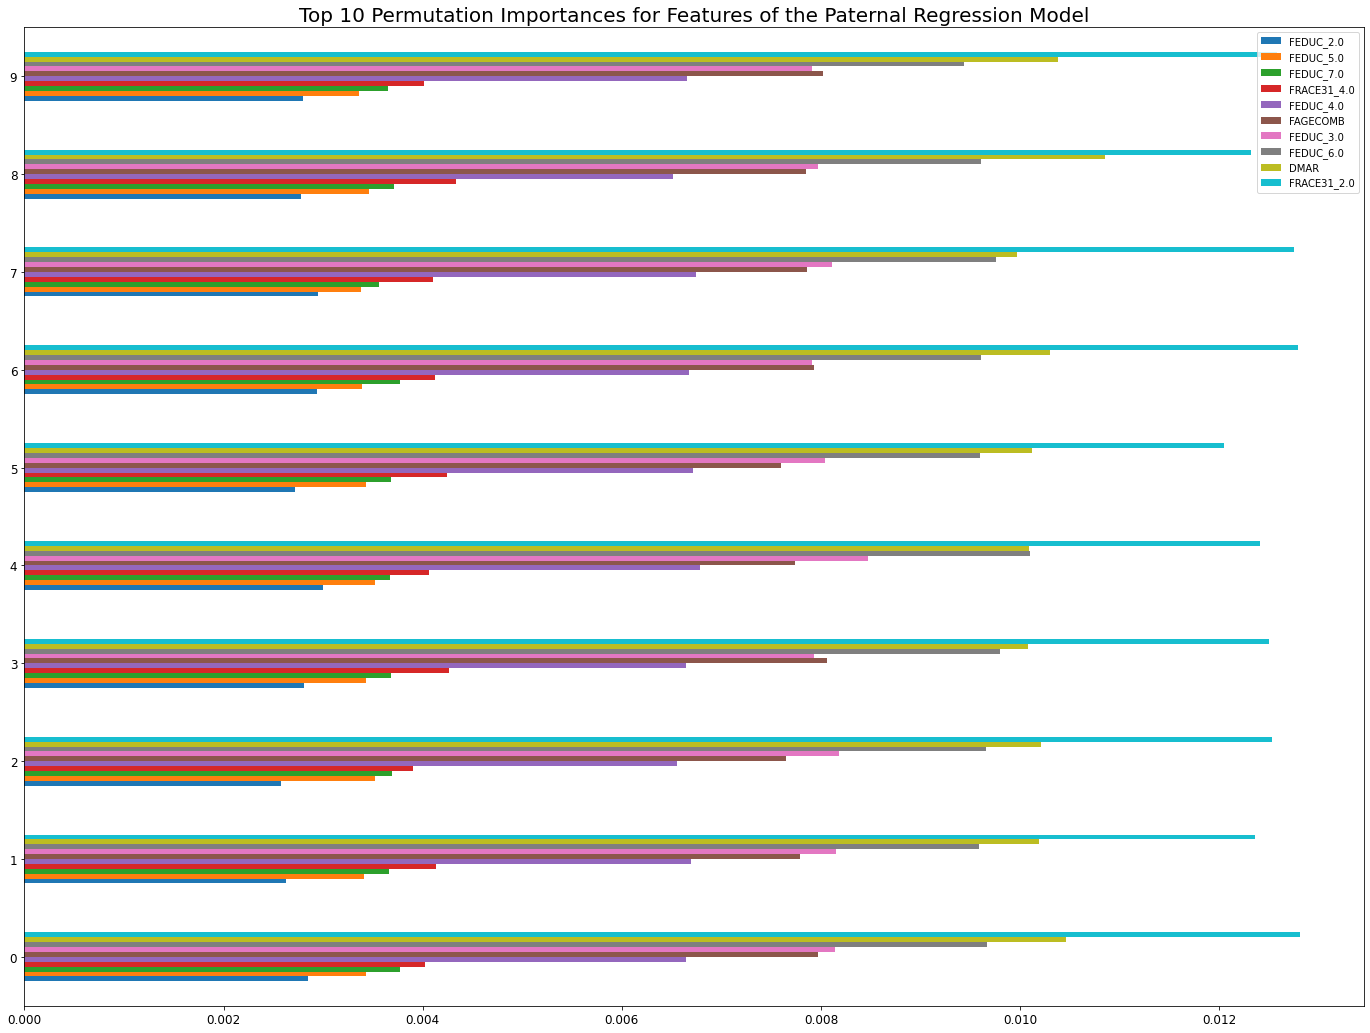

In [159]:
# Graph 10 most important features for paternal model
top_ax_reg_paternal = top_importances_reg_paternal.plot.barh(figsize=(24, 18))
top_ax_reg_paternal.set_title('Top 10 Permutation Importances for Features of the Paternal Regression Model')

In [ ]:
r_reg_paternal.importances_mean

In [ ]:
r_reg_paternal.importances_mean

### Maternal Model

In [ ]:
# permutation importance for maternal RandomForestRegressor Model
r_reg_maternal = permutation_importance(rf_reg_maternal, X_maternal_test, y_reg_test, n_repeats=10, random_state=42)

In [ ]:
# create pickle file
joblib.dump(r_reg_maternal, 'pi_reg_maternal.pkl')

In [160]:
# reload pickle file
r_reg_maternal = joblib.load('pi_reg_maternal.pkl')

In [161]:
# sort and prep permutation importances for graphs
sorted_importances_idx_reg_maternal = r_reg_maternal.importances_mean.argsort()

In [ ]:
importances_reg_maternal = pd.DataFrame(r_reg_maternal.importances[sorted_importances_idx_reg_maternal].T, columns=X_maternal_test.columns[sorted_importances_idx_reg_maternal])

In [162]:
top_importances_reg_maternal = pd.DataFrame(r_reg_maternal.importances[sorted_importances_idx_reg_maternal].T, columns=X_maternal_test.columns[sorted_importances_idx_reg_maternal]).iloc[:, -10:]

In [ ]:
## Graph permutation importance features for maternal model
ax_reg_maternal = importances_reg_maternal.plot.barh(figsize=(24, 18))
ax_reg_maternal.set_title('Permutation Importances for Features of the Maternal Regression Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Maternal Regression Model')

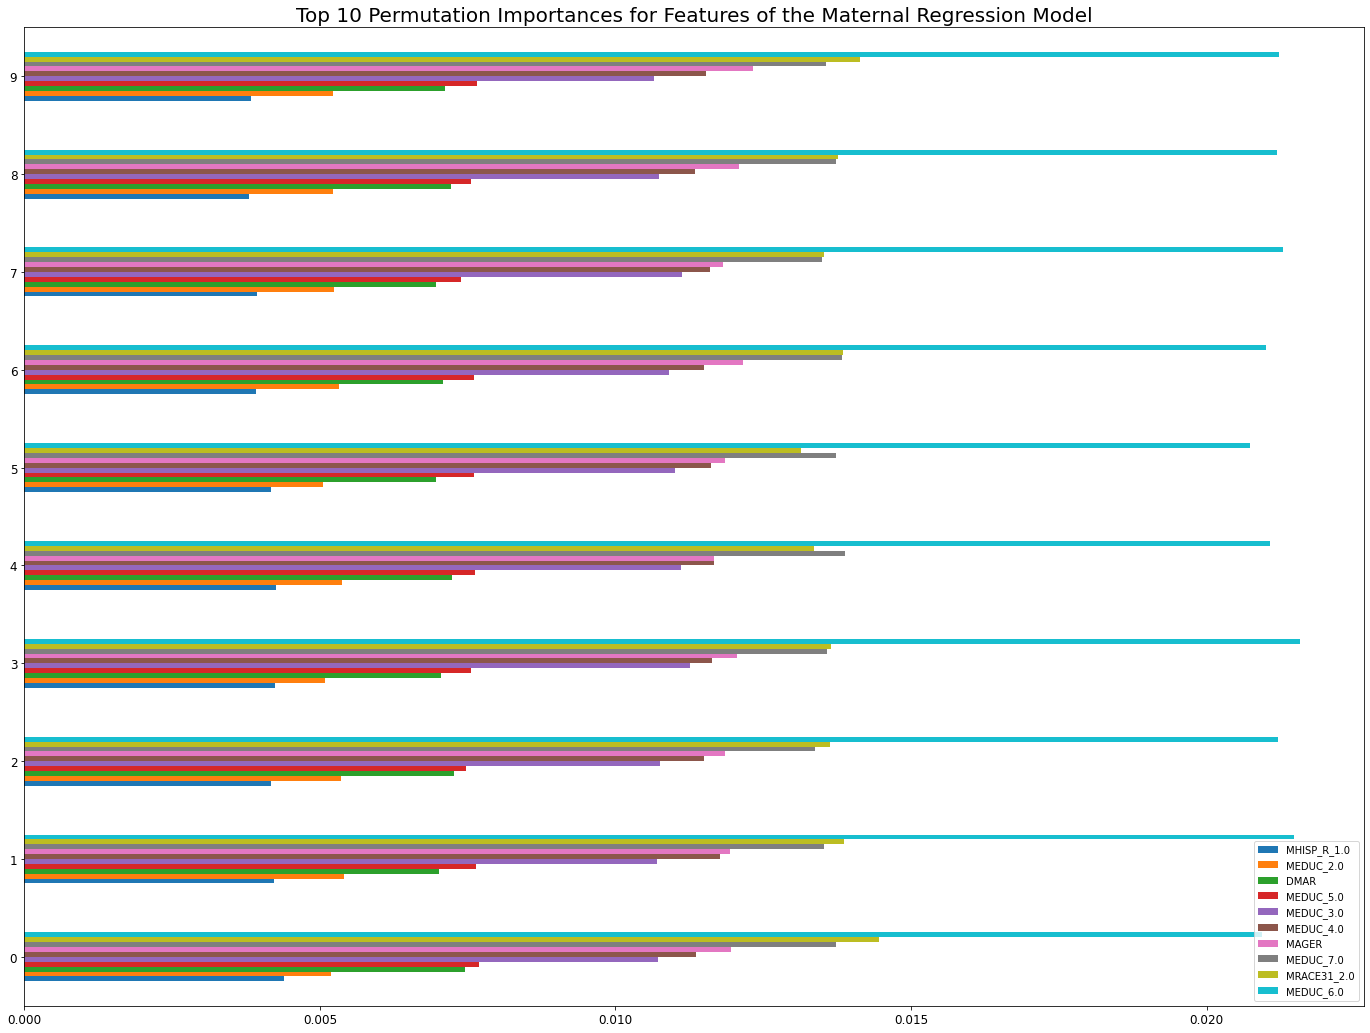

In [163]:
## Graph 10 most important features for maternal model
top_ax_reg_maternal = top_importances_reg_maternal.plot.barh(figsize=(24, 18))
top_ax_reg_maternal.set_title('Top 10 Permutation Importances for Features of the Maternal Regression Model')

In [ ]:
r_reg_maternal.importances_mean

In [ ]:
r_reg_maternal.importances

### Combined Model

In [24]:
# permutation importance for combined RandomForestRegressor Model
r_reg_combined = permutation_importance(optimal_rf_reg_combined, X_combined_test, y_reg_test, n_repeats=5, random_state=42)

In [25]:
# create pickle file
joblib.dump(r_reg_combined, 'pi_reg_combined.pkl')

['pi_reg_combined.pkl']

In [164]:
# reload pickle file
r_reg_combined = joblib.load('pi_reg_combined.pkl')

In [165]:
# sort and prep permutation importances for graphs
sorted_importances_idx_reg_combined = r_reg_combined.importances_mean.argsort()

In [27]:
importances_reg_combined = pd.DataFrame(r_reg_combined.importances[sorted_importances_idx_reg_combined].T, 
                                        columns=X_combined_test.columns[sorted_importances_idx_reg_combined])

In [166]:
top_importances_reg_combined = pd.DataFrame(r_reg_combined.importances[sorted_importances_idx_reg_combined].T, 
                                            columns=X_combined_test.columns[sorted_importances_idx_reg_combined]).iloc[:, -10:]

In [167]:
# Graph permutation importances for features of combined model
ax_reg_combined = importances_reg_combined.plot.barh(figsize=(24, 18))
ax_reg_combined.set_title('Permutation Importances for Features of the Combined Regression Model')

Text(0.5, 1.0, 'Top 10 Permutation Importances for Features of the Combined Regression Model')

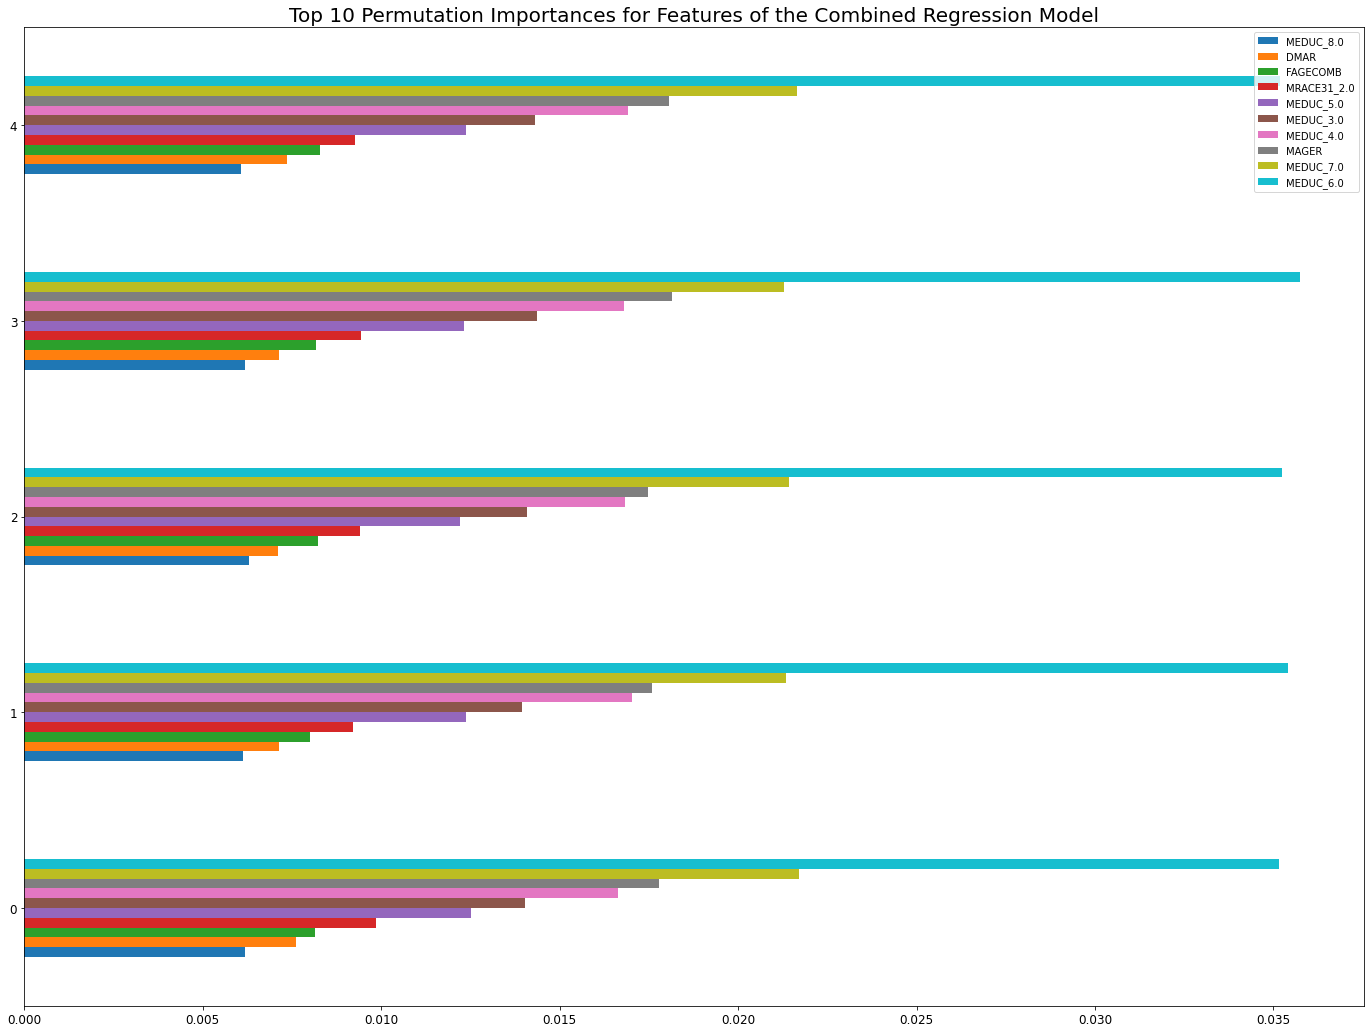

In [168]:
# Graph 10 most important features for combined model
top_ax_reg_combined = top_importances_reg_combined.plot.barh(figsize=(24, 18))
top_ax_reg_combined.set_title('Top 10 Permutation Importances for Features of the Combined Regression Model')

In [169]:
r_reg_combined.importances_mean

In [170]:
r_reg_combined.importances

## Visual Comparison of MultiOutputRegressor RandomForestRegressor Models

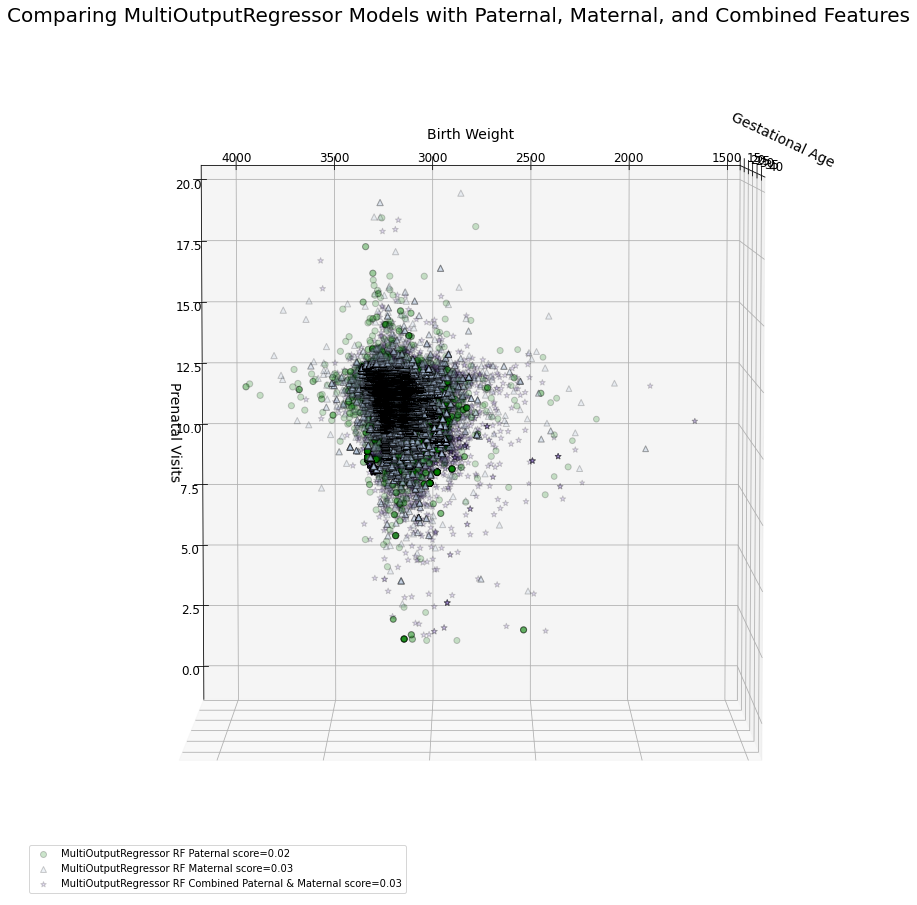

In [178]:
# Plot the results
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(20, 16))
ax = fig.add_subplot(111, projection='3d')

# Paternal features
plt.scatter(
    optimal_rf_reg_paternal_y_pred[:, 0],
    optimal_rf_reg_paternal_y_pred[:, 1],
    optimal_rf_reg_paternal_y_pred[:, 2],
    edgecolor="k",
    c="green",
    marker="o",
    alpha=0.2,
    label="MultiOutputRegressor RF Paternal score=%.2f" % optimal_rf_reg_paternal.score(X_paternal_test, y_reg_test),
)
# Maternal features 
plt.scatter(
    optimal_rf_reg_maternal_y_pred[:, 0],
    optimal_rf_reg_maternal_y_pred[:, 1],
    optimal_rf_reg_maternal_y_pred[:, 2],
    edgecolor="k",
    c="lightsteelblue",
    marker="^",
    alpha=0.2,
    label="MultiOutputRegressor RF Maternal score=%.2f" % optimal_rf_reg_maternal.score(X_maternal_test, y_reg_test),
)
# Combined Paternal and Maternal features  
plt.scatter(
    optimal_rf_reg_combined_y_pred[:, 0],
    optimal_rf_reg_combined_y_pred[:, 1],
    optimal_rf_reg_combined_y_pred[:, 2],
    edgecolor="k",
    c="mediumpurple",
    marker="*",
    alpha=0.2,
    label="MultiOutputRegressor RF Combined Paternal & Maternal score=%.2f" % optimal_rf_reg_combined.score(X_combined_test, y_reg_test),
)

ax.set_xlabel("Prenatal Visits")
ax.set_ylabel("Birth Weight")
ax.set_zlabel('Gestational Age')
ax.set_zlim(15, 43)
ax.view_init(95, 180)
ax.set_title("Comparing MultiOutputRegressor Models with Paternal, Maternal, and Combined Features")
ax.legend(loc=3)
plt.show()

## Discussion of Results

Based on the results, it seems that inclusion of paternal demographic characteristics does not add much useful information in predicting prenatal and perinatal outcomes. While the combined classification and regression models showed some relative improvement over the maternal models, the classification model was still only accurate in about three out of four predictions, and the regression model only predicts a small portion of the variance (R<sup>2</sup> = 0.03).  Findings were consistent with previous research (Mutsaerts et al., 2014) that paternal factors do not seem to provide unique information beyond maternal factors.  Future research should examine the most important features, such as marital status and mother's education level, more closely to see how they might be useful in public health education campaigns aimed to improve pregnancy outcomes while also considering other variables that may have better predictive ability.

## References

Meinert, R.  (2019, June 5). Optimizing hyperparameters in random forest classification.  Toward Data Science. https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

Mutsaerts, M. A. Q., Groen, H., Buiter-Van der Meer, A., Sijtsma, A., Sauer, P. J. J., Land, J. A., Mol, B. W., Corpeleijn, E., & Hoek, A.  (2014).  Effects of paternal and maternal lifestyle factors on pregnancy complications and perinatal outcome.  A population-based birth-cohort study: the GECKO Drenthe cohort.  Human Reproduction, 29(4), 824-834. https://doi.org/10.1093/humrep/deu006 
